<a href="https://colab.research.google.com/github/dbuch2004/Dsgn_Opt/blob/rocketlanding/Project_1_MAE_598_new_upload_5th_december.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 1 : MAE 598 Design Optimization 
Name : Dhiram Ashok Buch 

In [ ]:
#import library and dependencies
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt


In [ ]:
#given parameter
FRAME_TIME = 0.1  
GRAVITY_ACCEL_X = 0.0
GRAVITY_ACCEL_Y = 0.12
BOOST_ACCEL = 0.15 
Cd = 1
rho = 0.08
A = 0.1

In [ ]:
# making system dynamics 

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
      
        """
        Here the system state is defined by 5 parameters: 
          1) "x"     -----> The displacement of the rocket in x-direction
          2) "y"     -----> The displacement of the rocket in y-direction
          3) "x_dot" -----> The velocity of the rocket in x-direction
          4) "y_dot" -----> The velocity of the rocket in y-direction
          5) "theta" -----> The angle of rotation of the rocket about its center of mass

        The array "state" stores the five system states defined above.
        state[0] = x
        state[1] = y
        state[2] = x_dot
        state[3] = y_dot
        state[4] = theta
        """
        delta_state_gravity = torch.tensor([0., 0.,-GRAVITY_ACCEL_X * FRAME_TIME, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])

        # Calculating the Thrust for the given state
        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 2] = torch.cos(state[0, 4])
        state_tensor[0, 3] = torch.sin(state[0, 4])
    
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))


        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),(action[0, 1]).reshape(-1, 1))
  
        Vy = torch.matmul(state,torch.tensor([0., 0., 0., 1., 0.]))
        drag_y = -rho*Vy*Vy*A*Cd

        state = state + delta_state  + delta_state_gravity + delta_state_theta - drag_y

        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1.,0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        state = torch.matmul(step_mat, state.T)     
        return state.T

In [ ]:
#defining controller
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input:  Number of system states
        dim_output: Number of actions
        dim_hidden: Number of hidden layers
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid(),
            nn.Linear(dim_output,  dim_hidden),
            nn.Tanh(),
            nn.Linear( dim_hidden, dim_output),
            nn.Sigmoid())
    def forward(self, state):
        action = self.network(state)
        action = (2*action - torch.tensor([0., 1])) 
        return action
     

In [ ]:
#making simulation model
class Simulation(nn.Module):
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[-2.,2.,0.,0.,0.]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
    
        return torch.mean(state ** 2)
     

In [ ]:
#making optimizer
class Optimize:    
    def __init__(self, simulation):
        self.simulation = simulation                            
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.007)
        self.loss_list = []


    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state) 
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

   
    def train(self, epochs):
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() 
            self.loss_list.append(loss) 
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()

        
        
    # Plotting the states
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 6, tight_layout = 1, figsize = (25, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Position Plot (y vs x) at {self.epoch + 1} iteration')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity in (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Change in Velocity for {self.epoch + 1} iteration')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta in (rad)")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Change in Theta for {self.epoch + 1} iteration')

        ax[3].plot(frame, thrust, c = 'k', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust in (N)")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Change in Thrust for {self.epoch + 1} iteration')

        ax[4].plot(x, vx, c = 'm', label = "Velocity in x")
        ax[4].set_xlabel("Position in x")
        ax[4].set_ylabel("Velocity in x in (m/s)")
        ax[4].legend(frameon=0)
        ax[4].set(title =f'Velocity in x w.r.t x')

        ax[5].plot(y, vy, c = 'm', label = "Velocity in y")
        ax[5].set_xlabel("Position in y")
        ax[5].set_ylabel("Velocity in y in (m/s)")
        ax[5].legend(frameon=0)
        ax[5].set(title =f'Velocity in y w.r.t y')

        plt.show()
     

[1] loss: 4.883


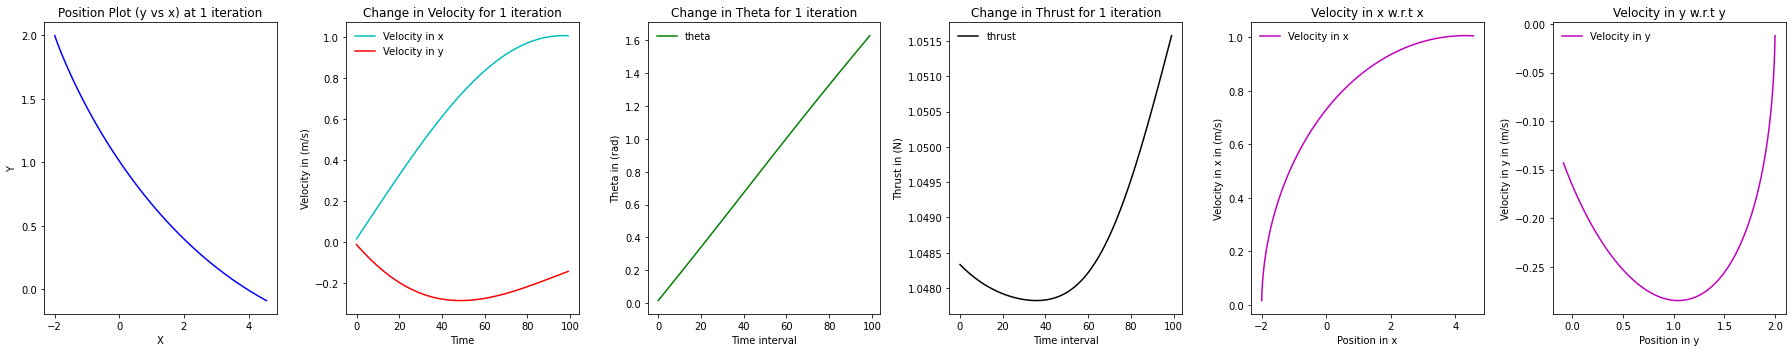

[2] loss: 3.672


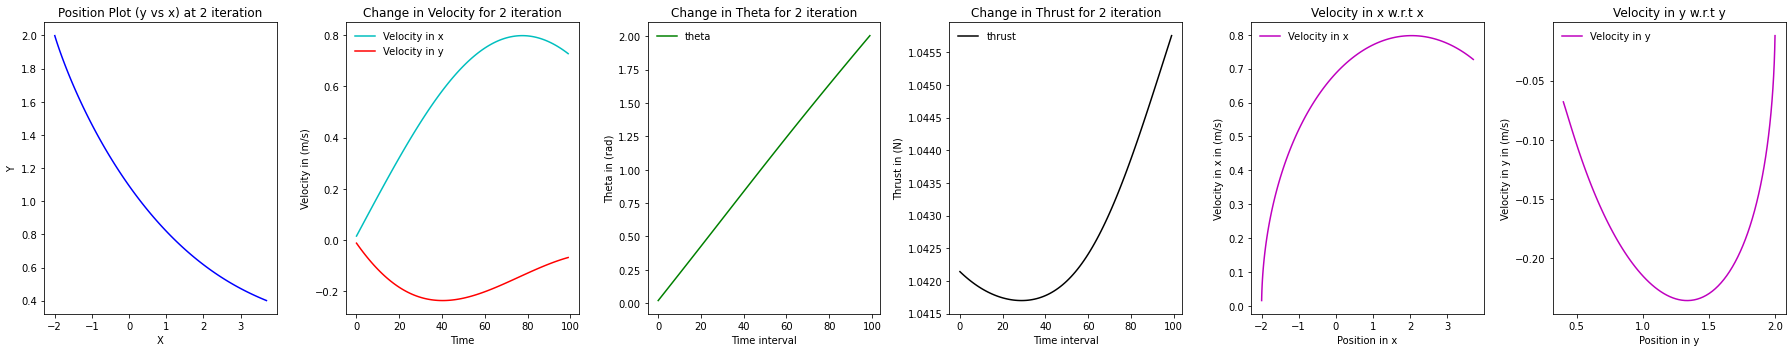

[3] loss: 3.058


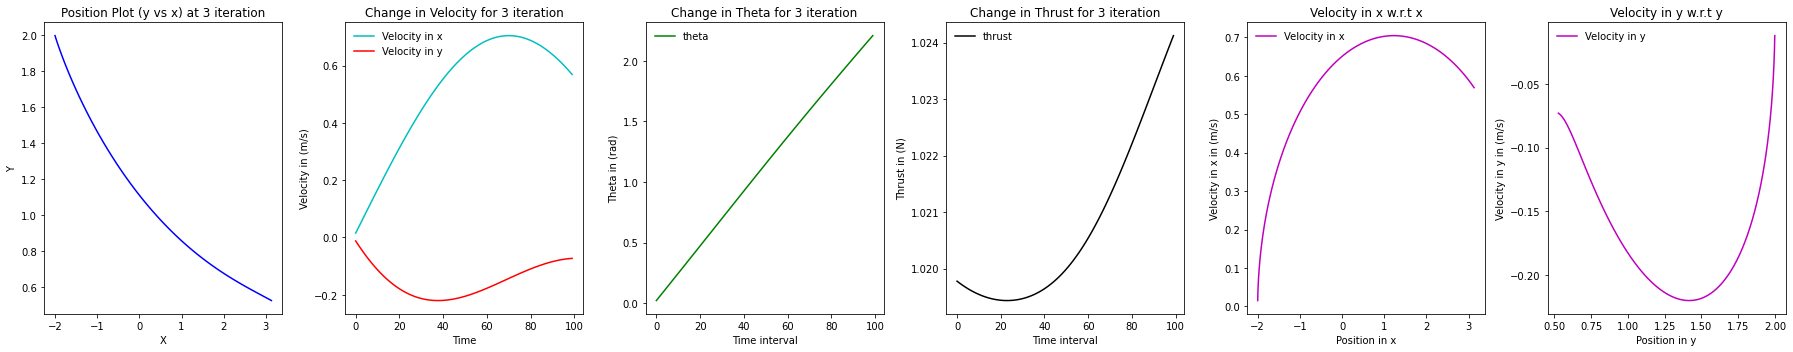

[4] loss: 2.652


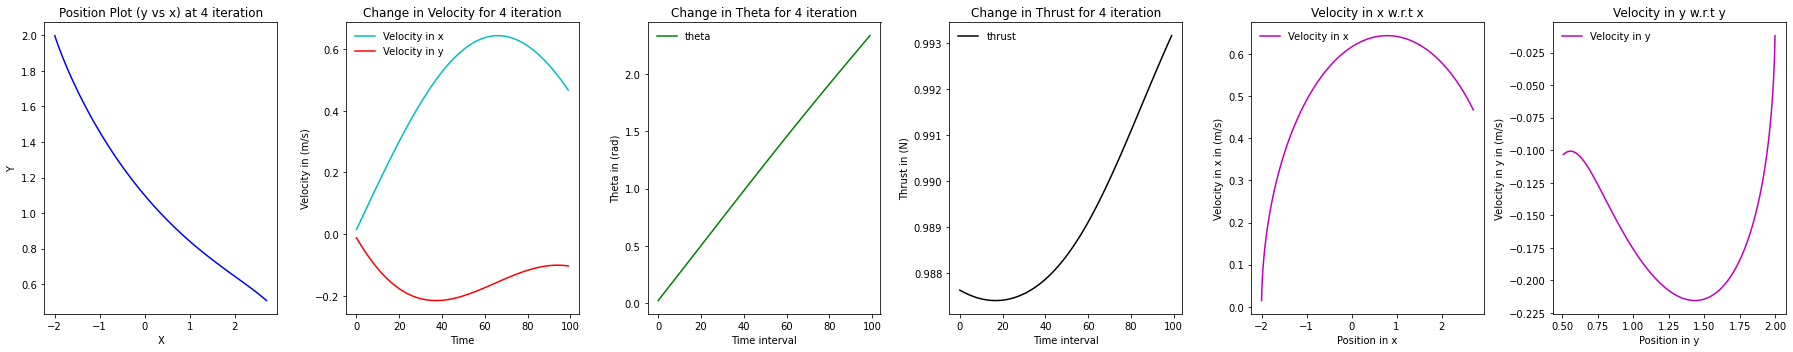

[5] loss: 2.358


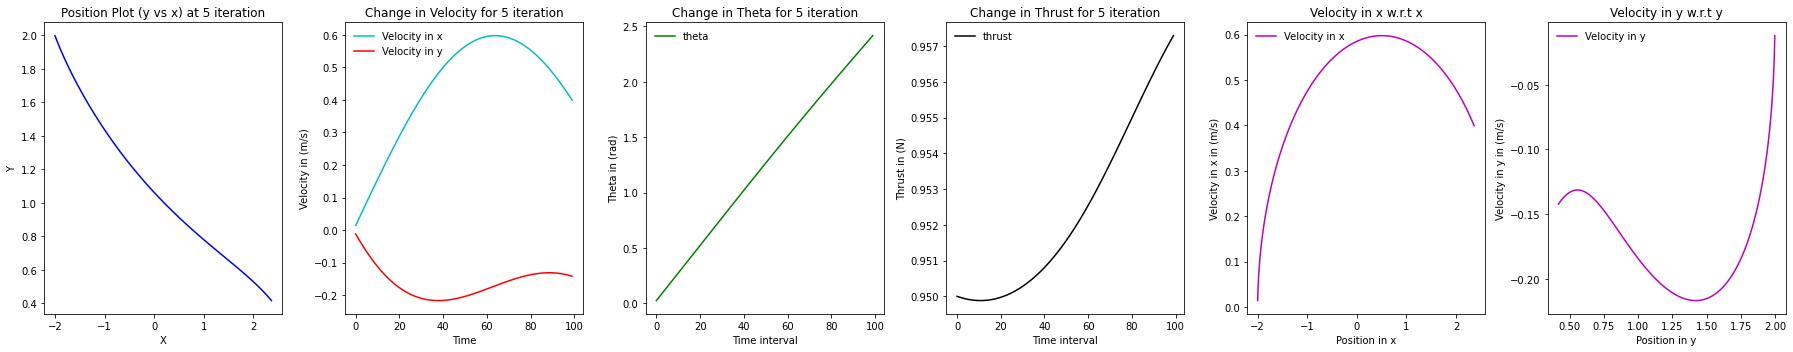

[6] loss: 2.137


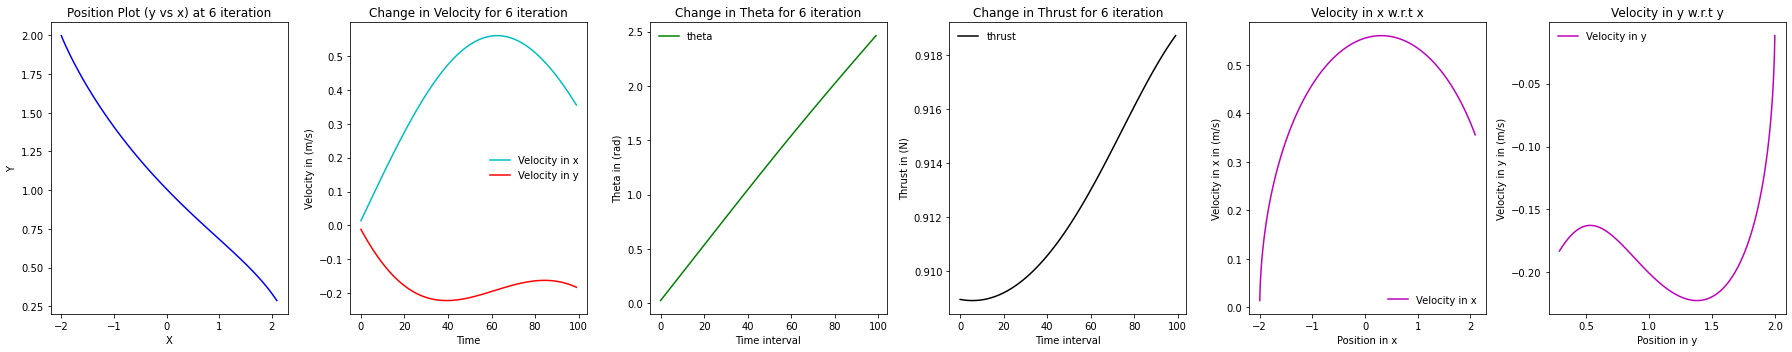

[7] loss: 1.951


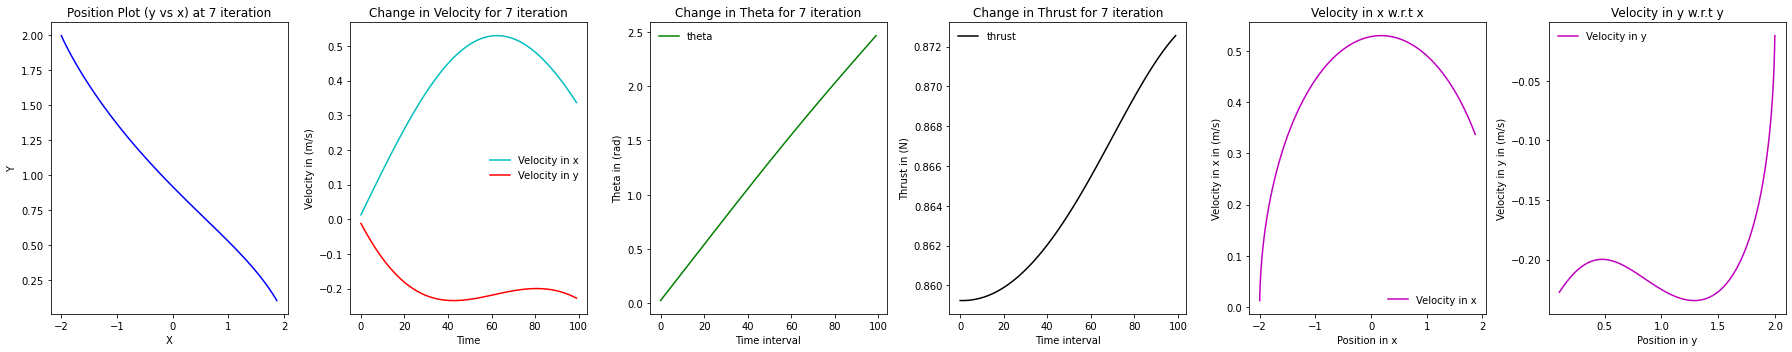

[8] loss: 1.795


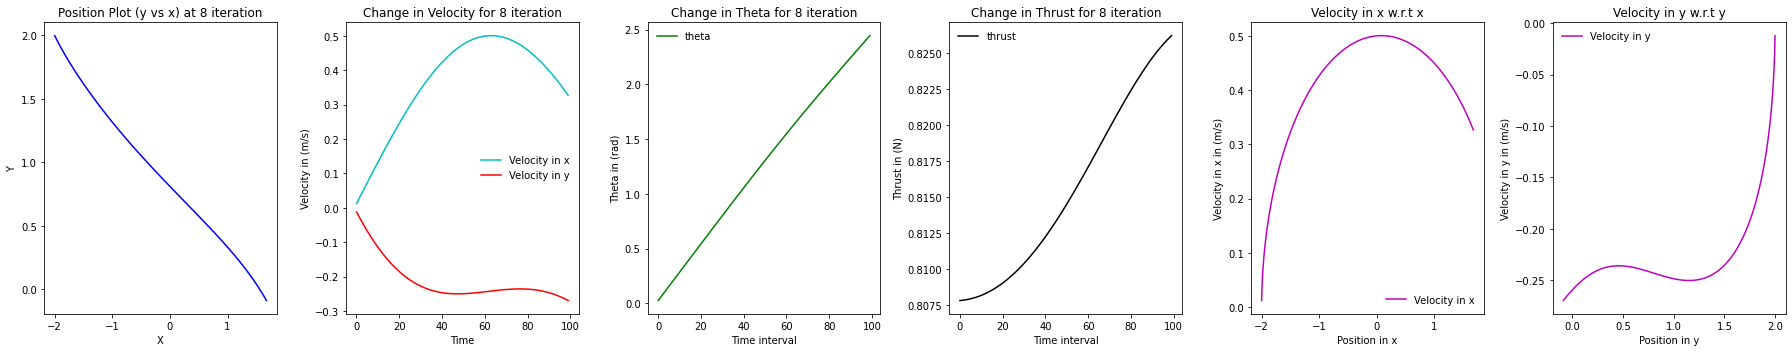

[9] loss: 1.668


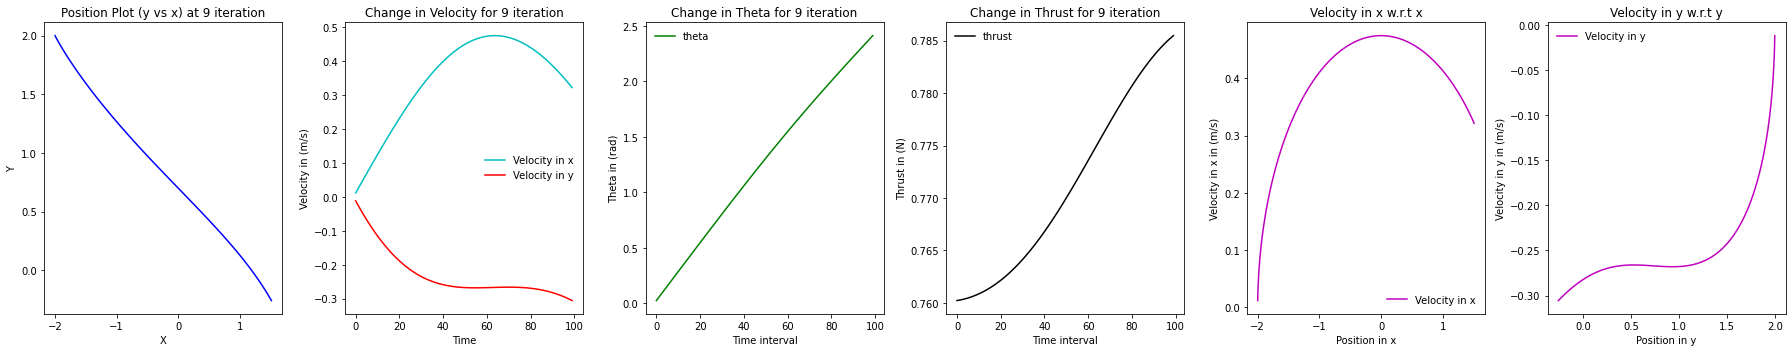

[10] loss: 1.470


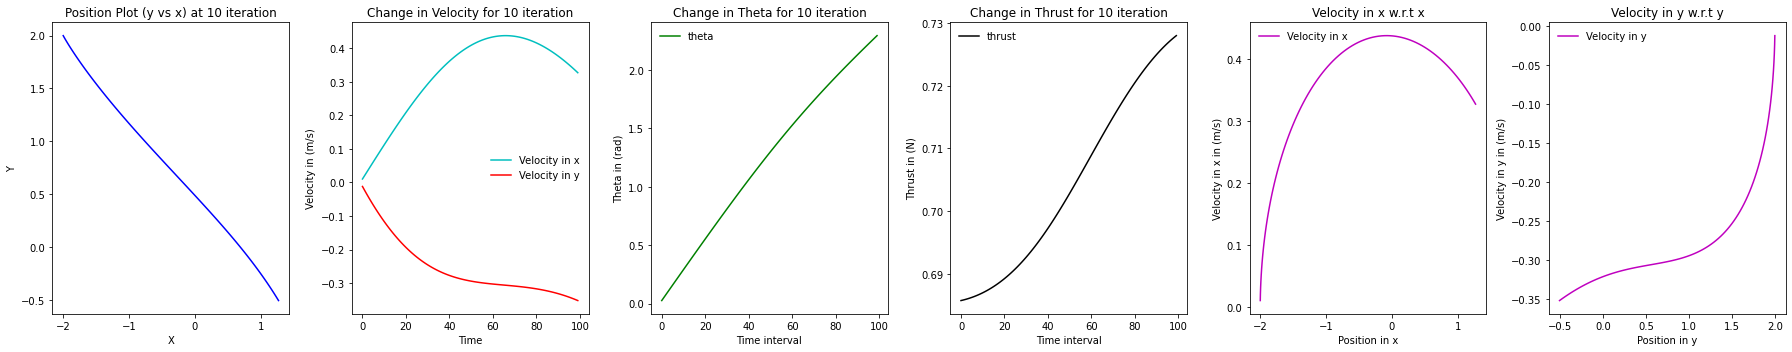

[11] loss: 1.017


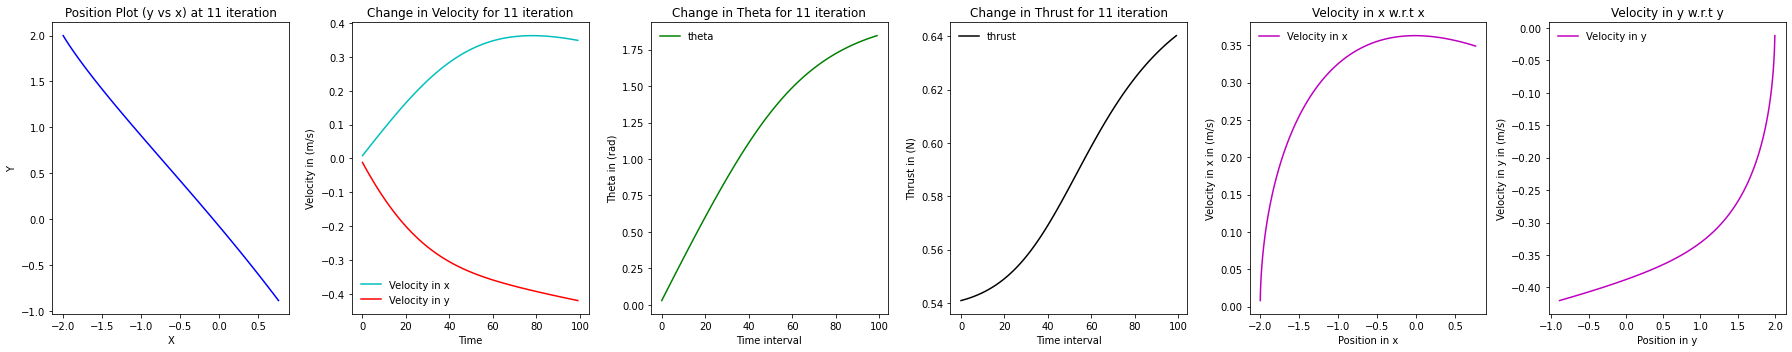

[12] loss: 0.572


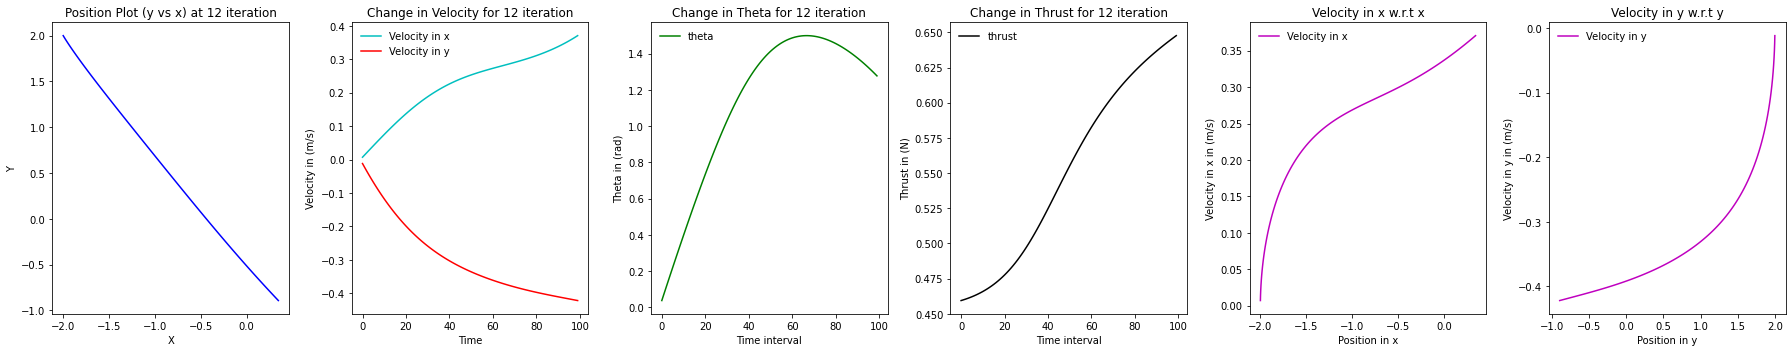

[13] loss: 0.356


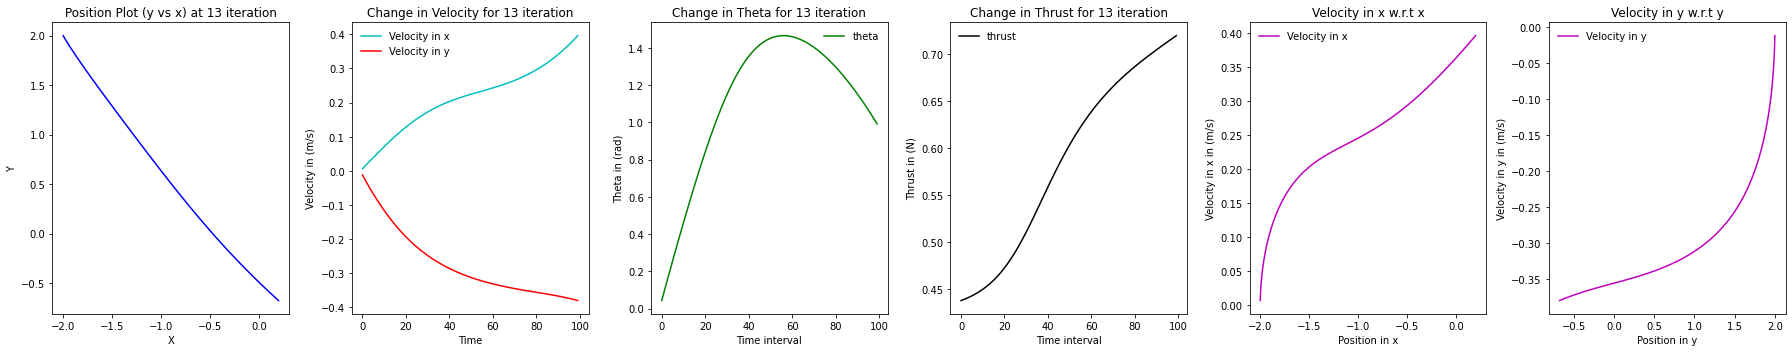

[14] loss: 0.256


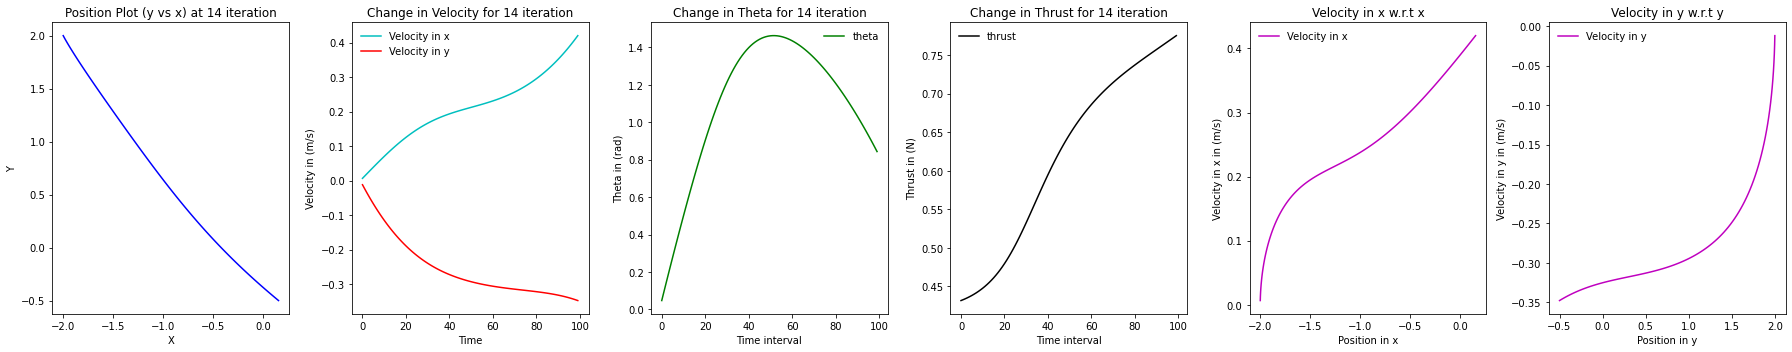

[15] loss: 0.202


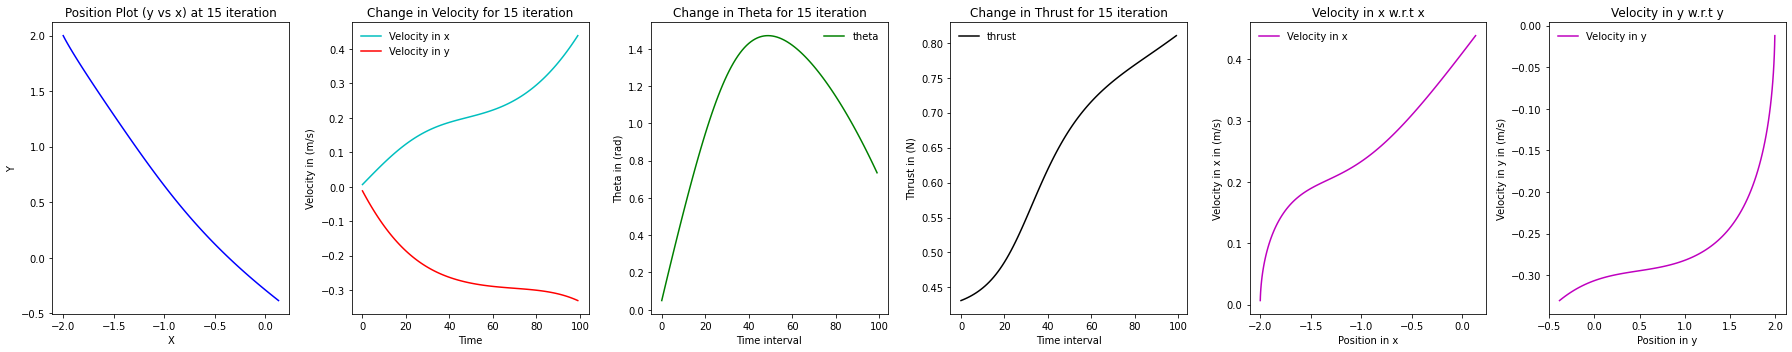

[16] loss: 0.166


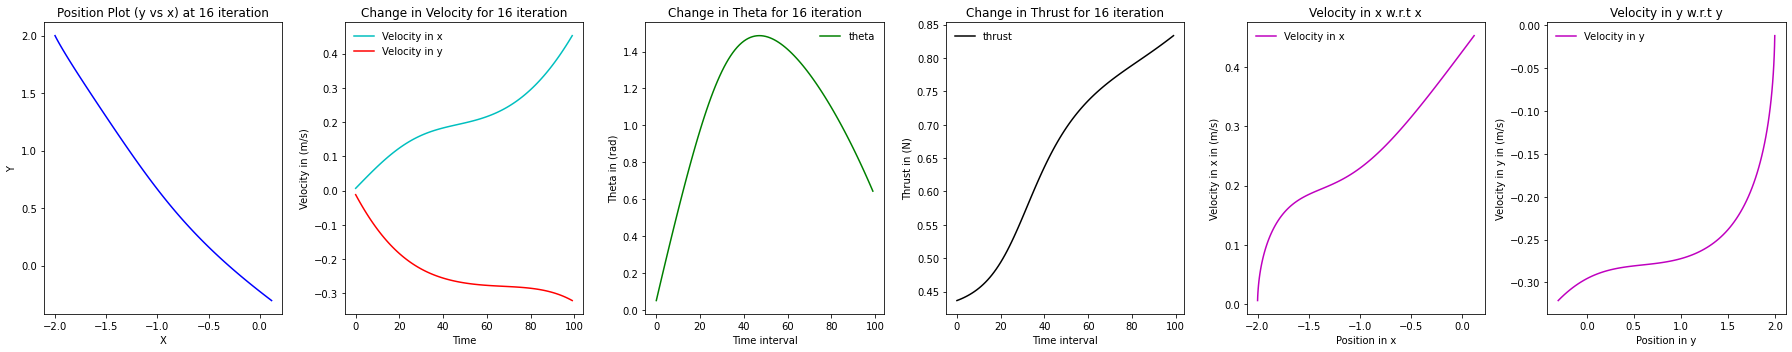

[17] loss: 0.139


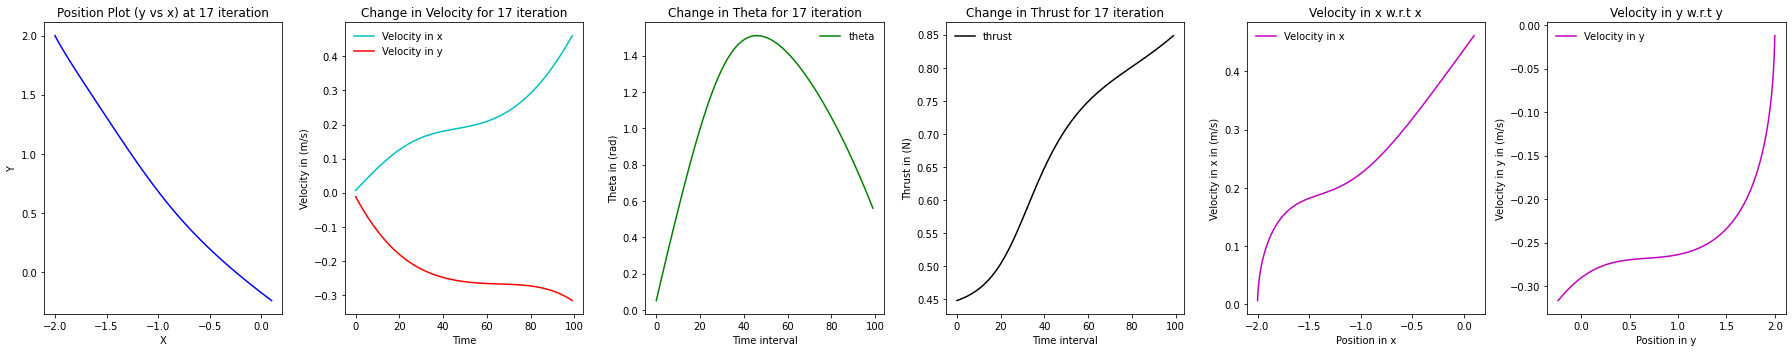

[18] loss: 0.117


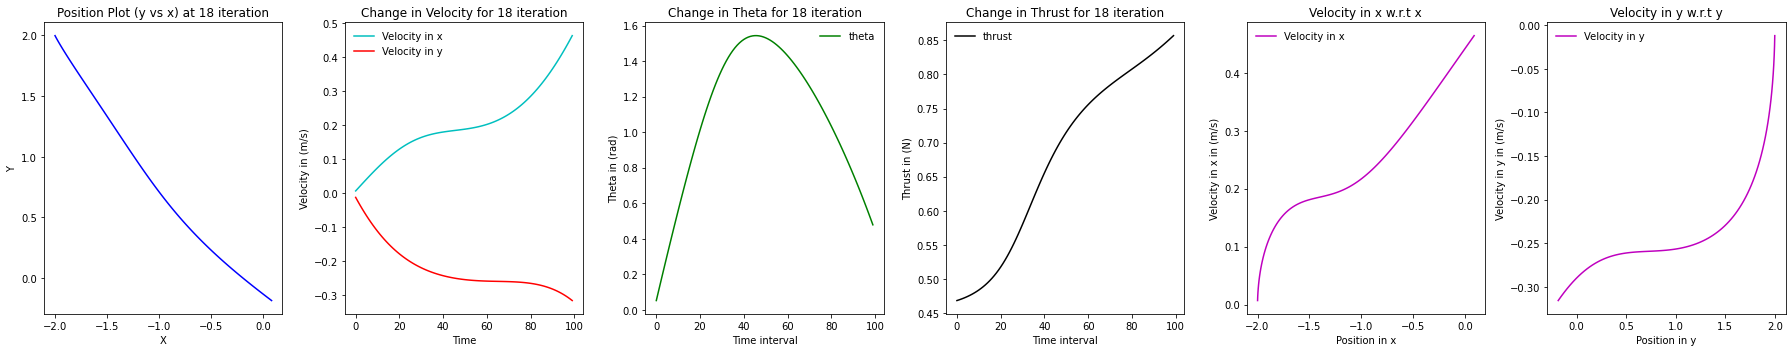

[19] loss: 0.096


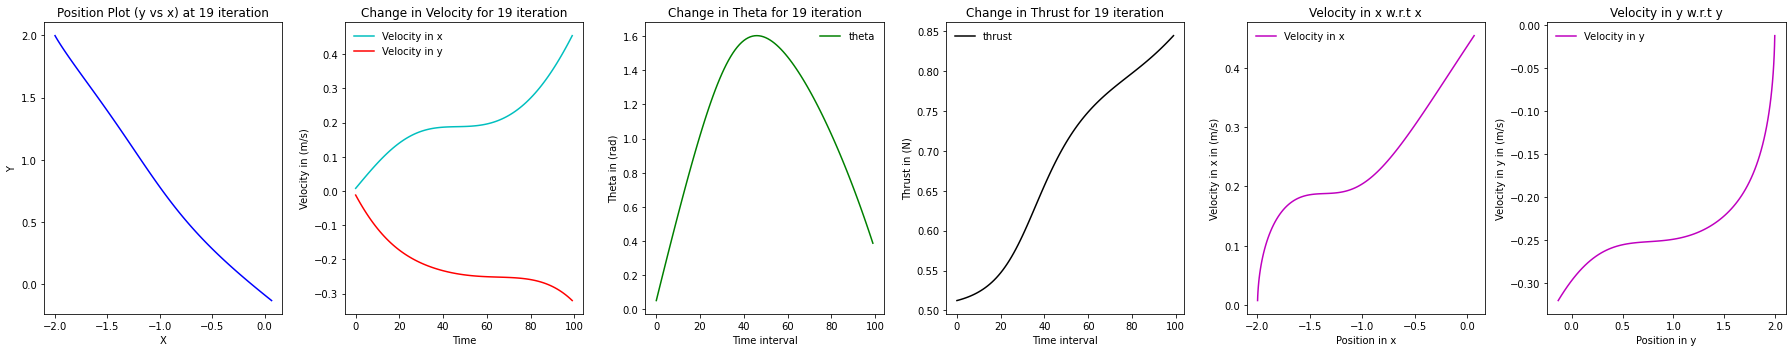

[20] loss: 0.079


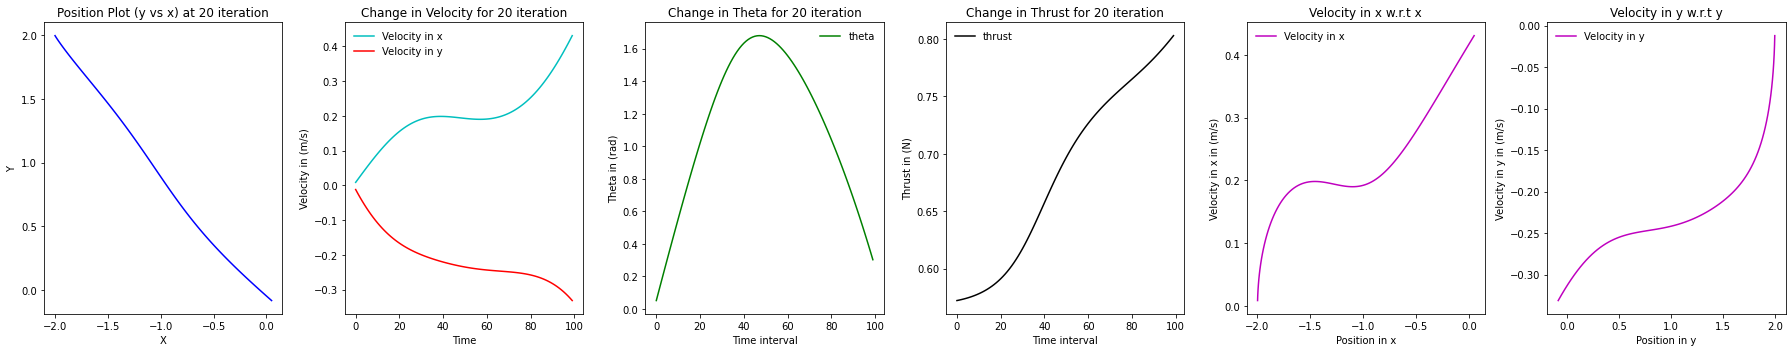

[21] loss: 0.069


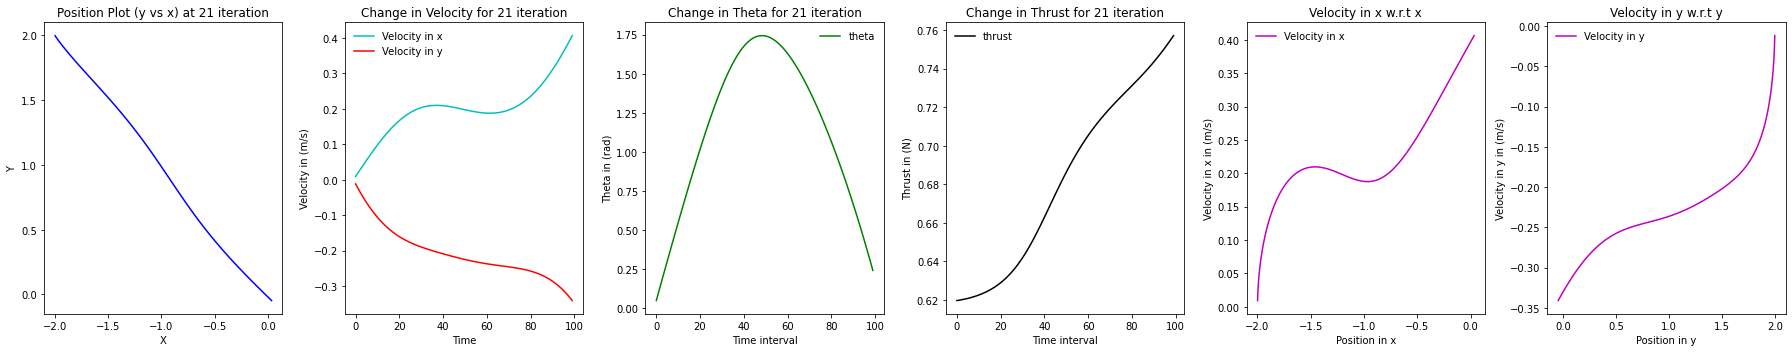

[22] loss: 0.062


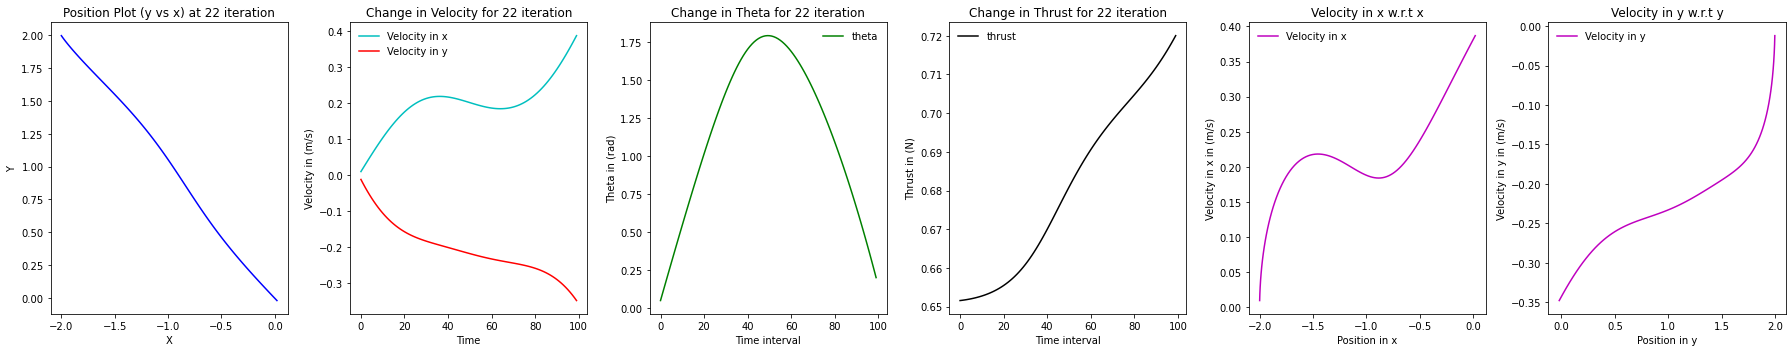

[23] loss: 0.058


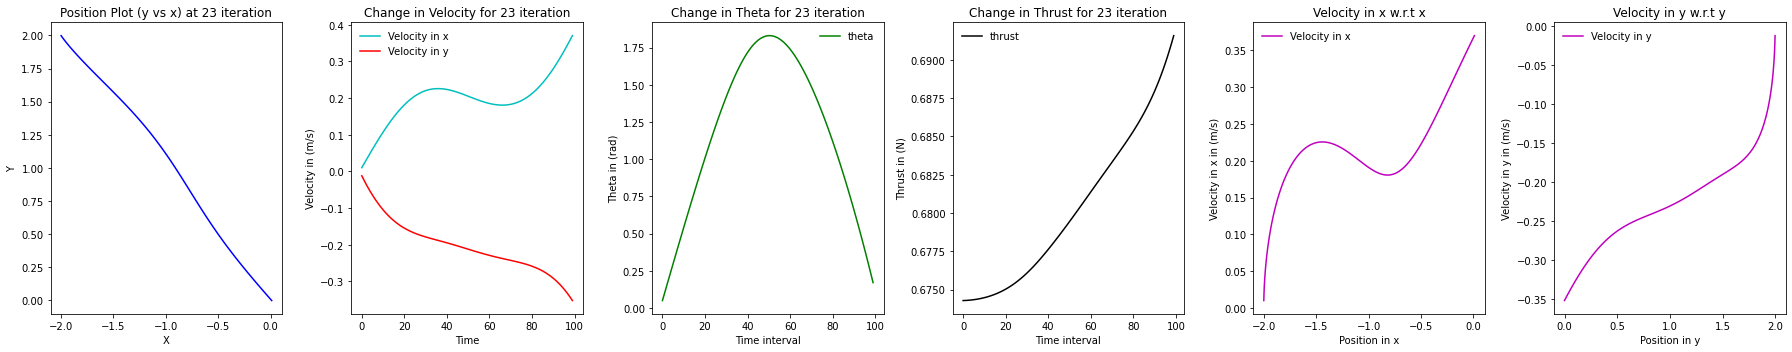

[24] loss: 0.055


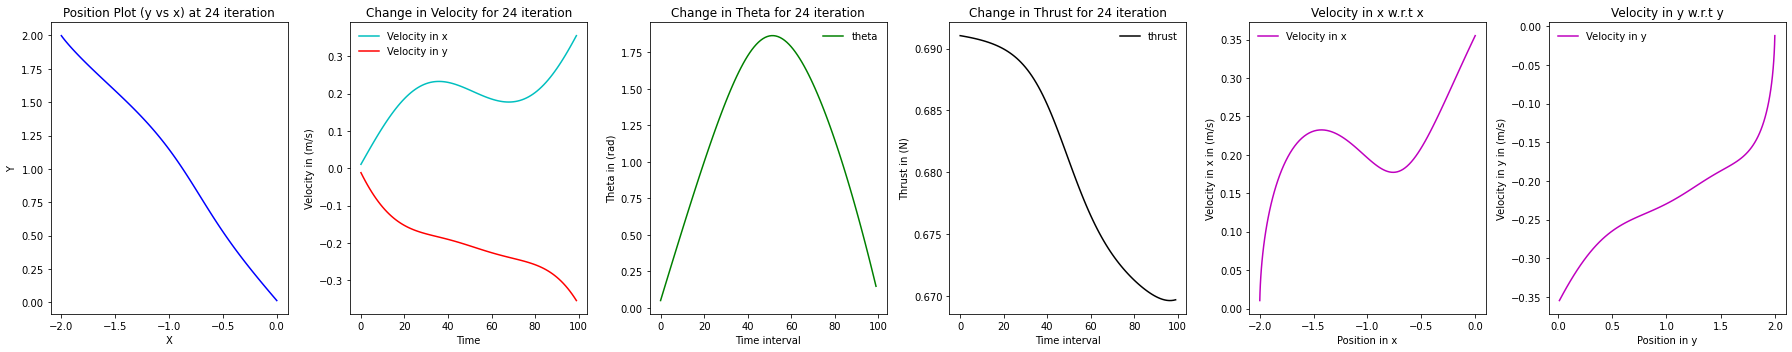

[25] loss: 0.052


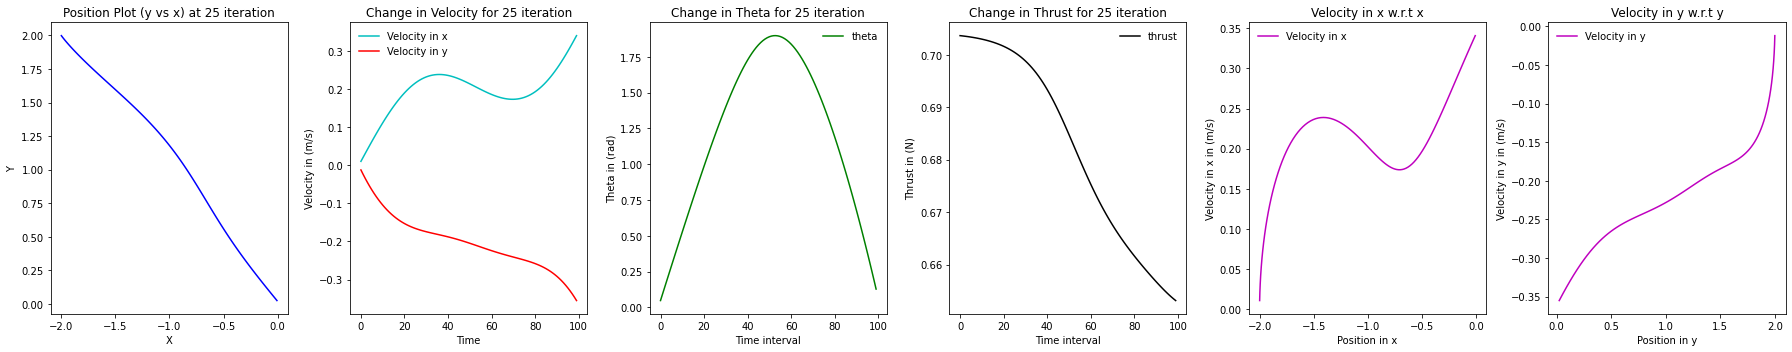

[26] loss: 0.049


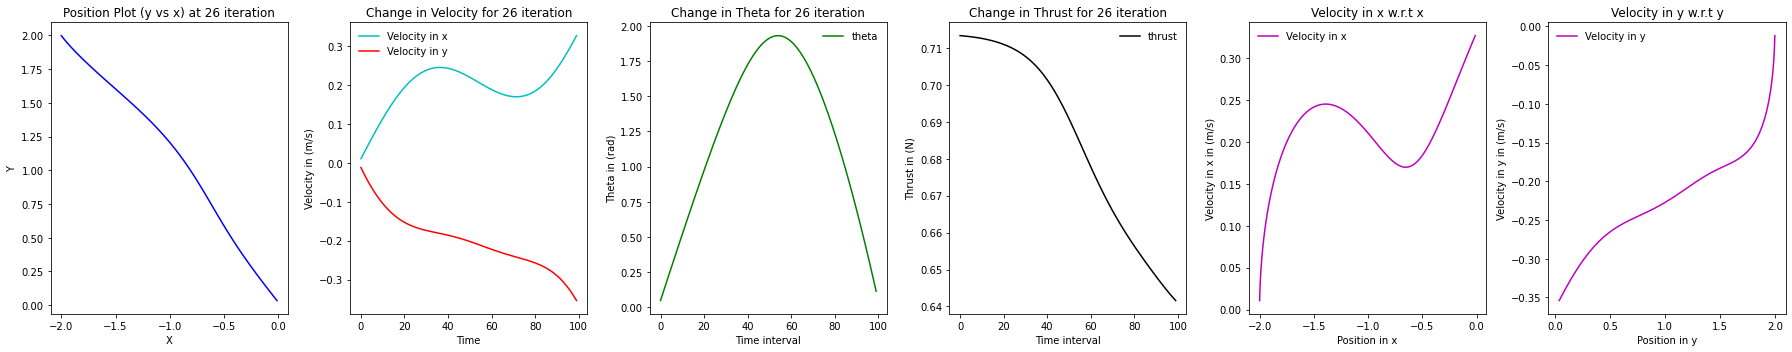

[27] loss: 0.047


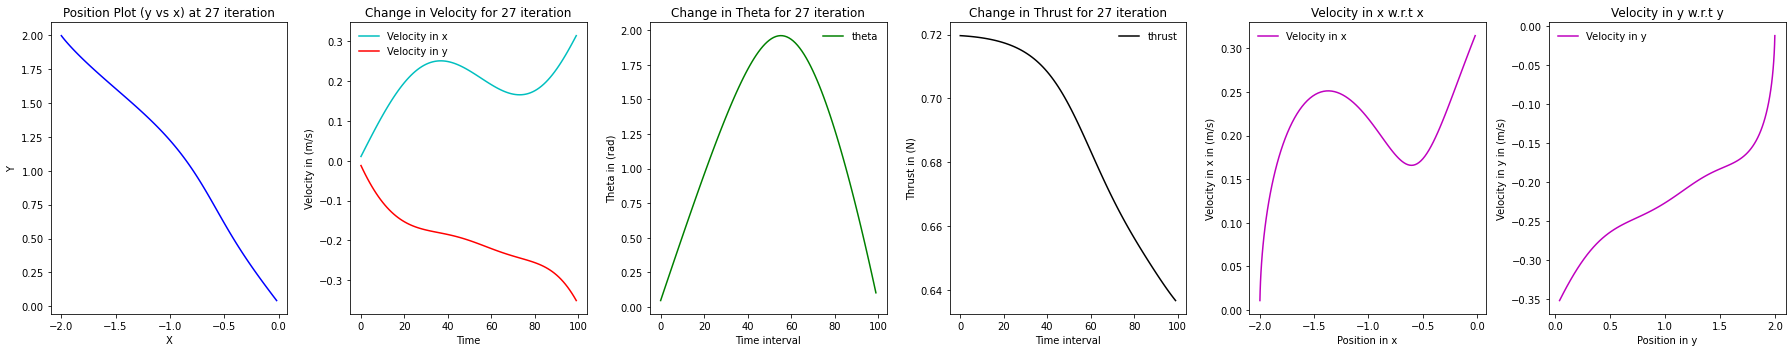

[28] loss: 0.045


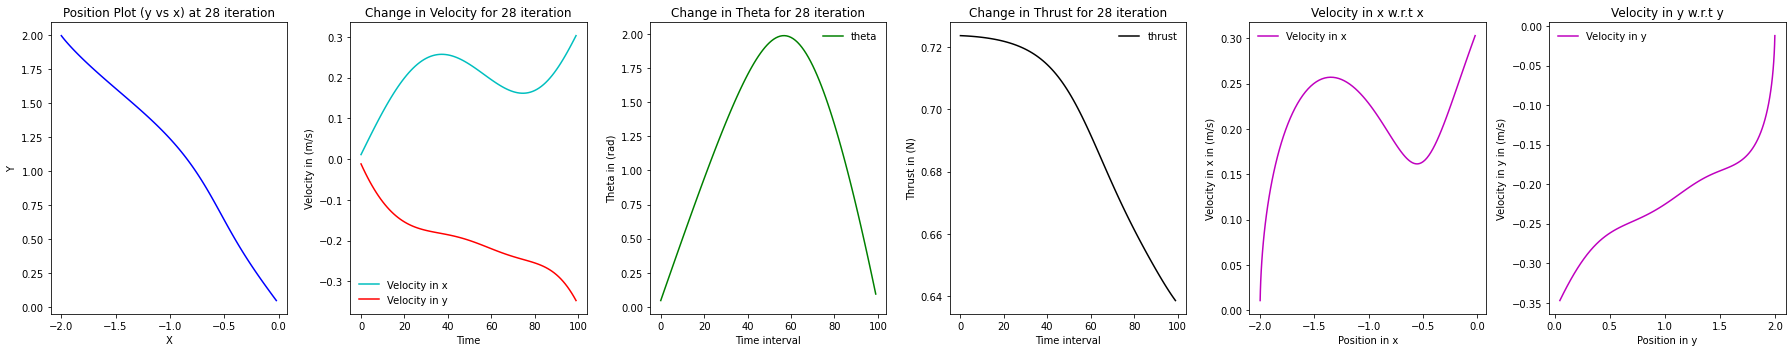

[29] loss: 0.043


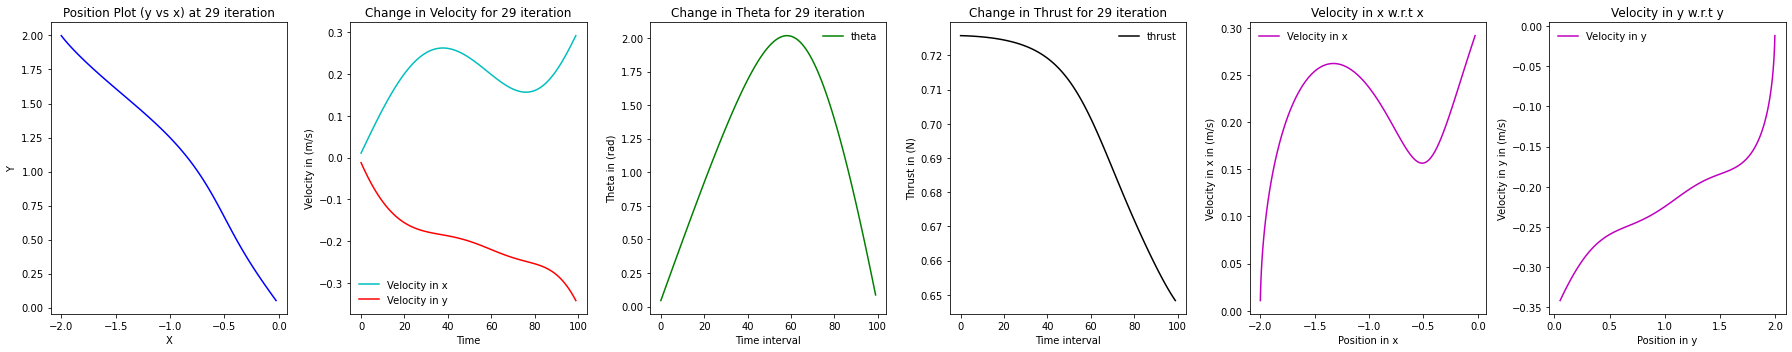

[30] loss: 0.040


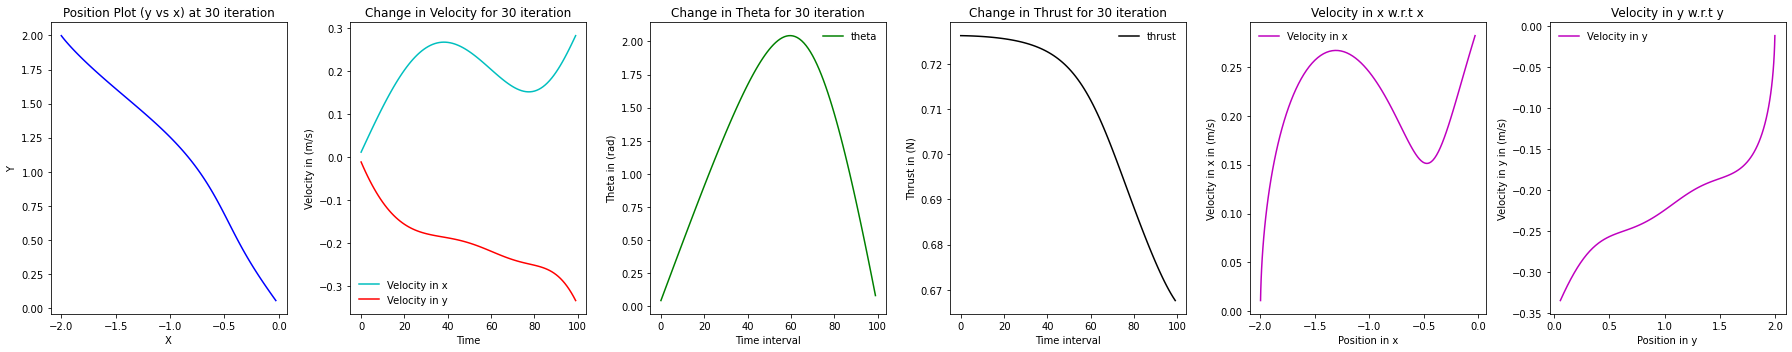

[31] loss: 0.038


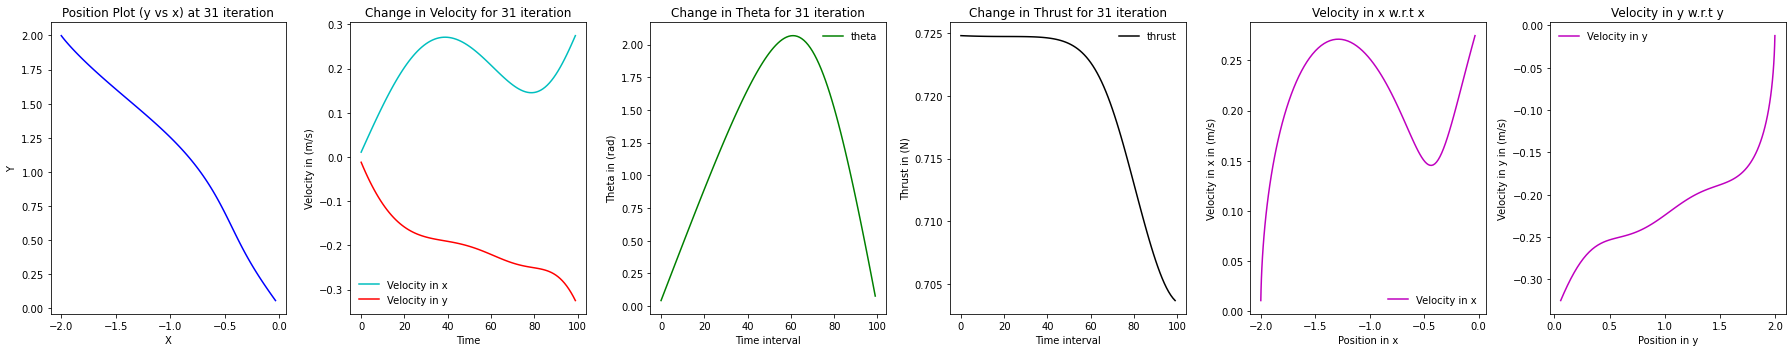

[32] loss: 0.036


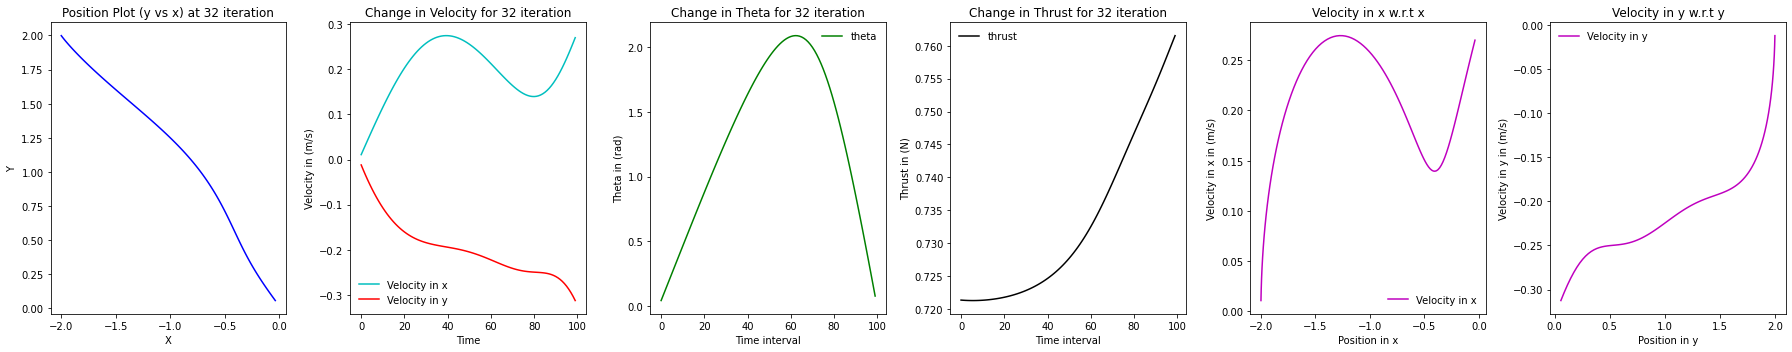

[33] loss: 0.034


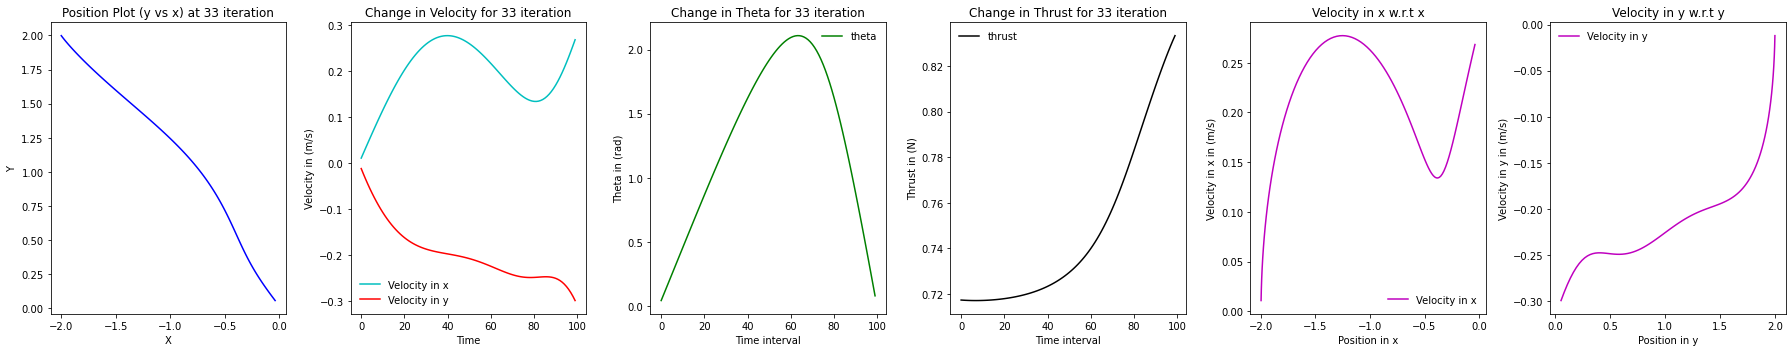

[34] loss: 0.033


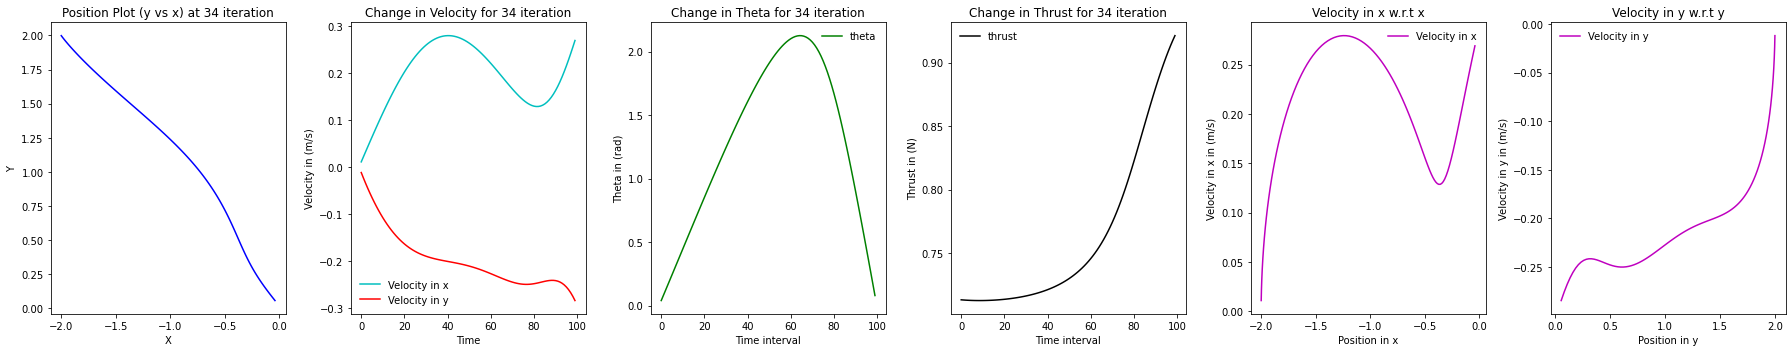

[35] loss: 0.031


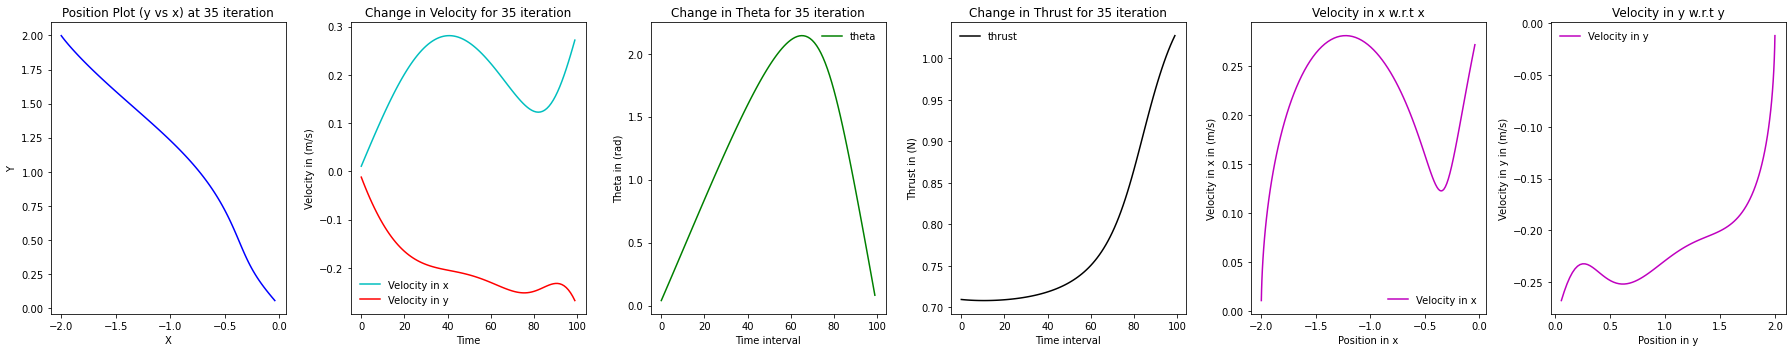

[36] loss: 0.029


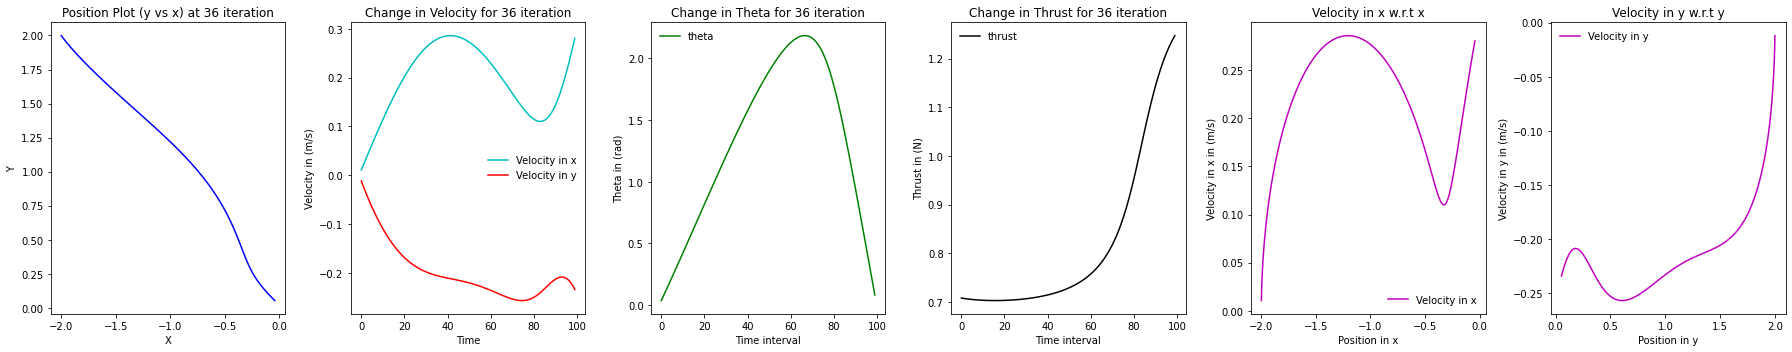

[37] loss: 0.028


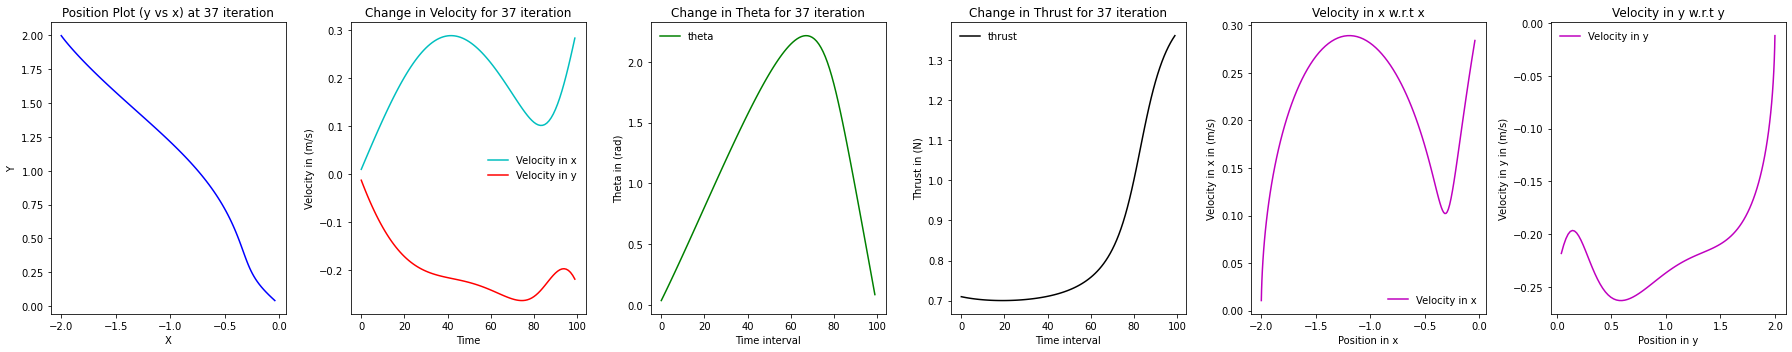

[38] loss: 0.027


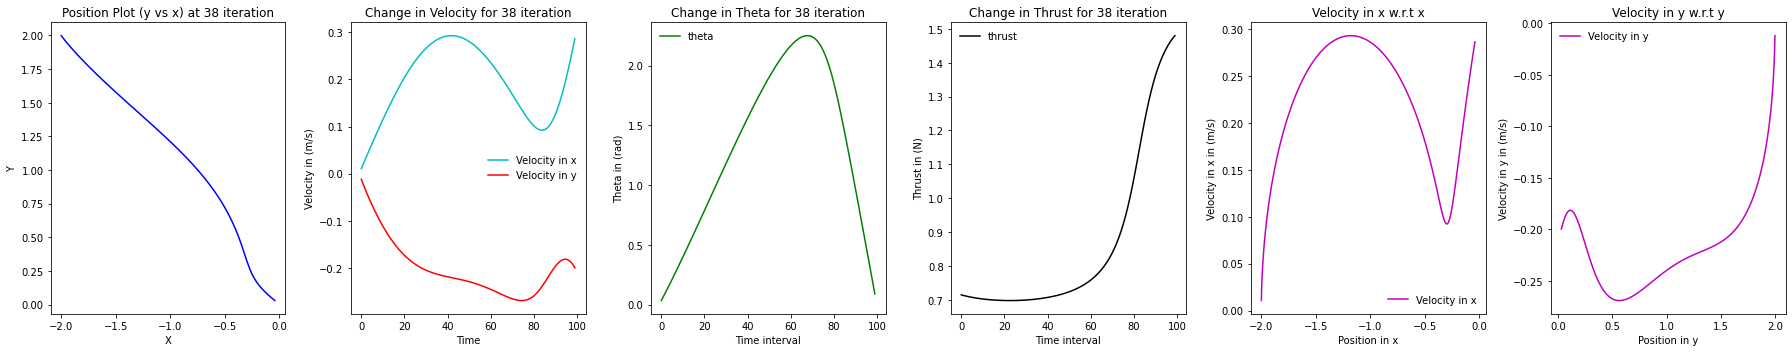

[39] loss: 0.026


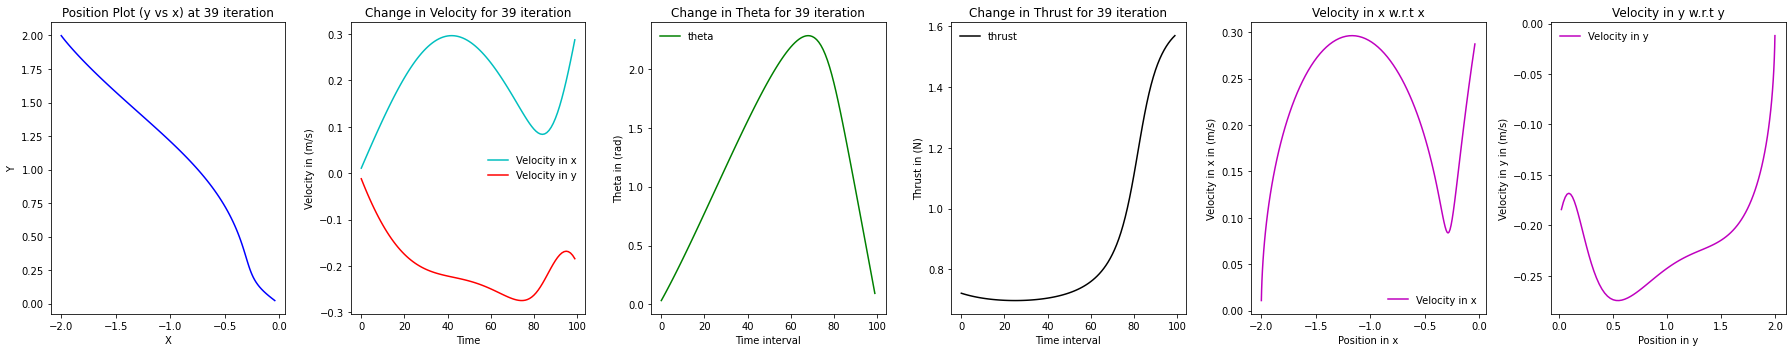

[40] loss: 0.025


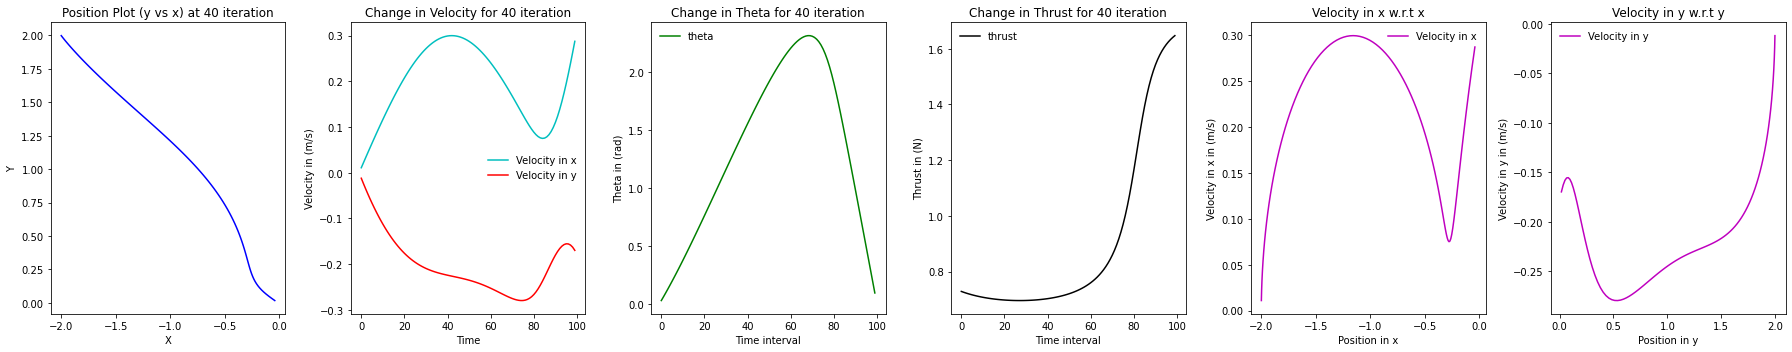

[41] loss: 0.024


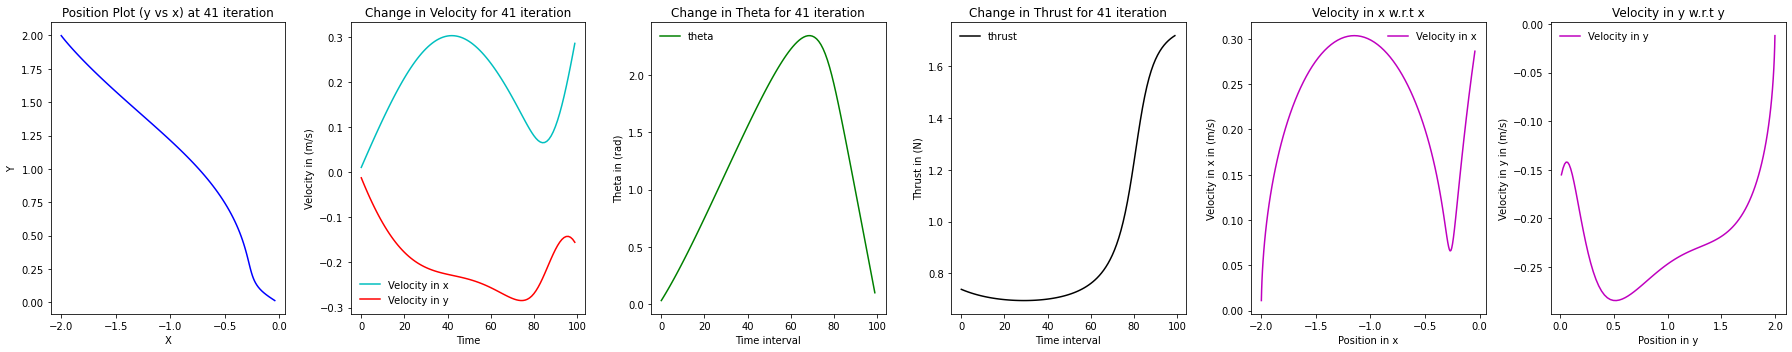

[42] loss: 0.023


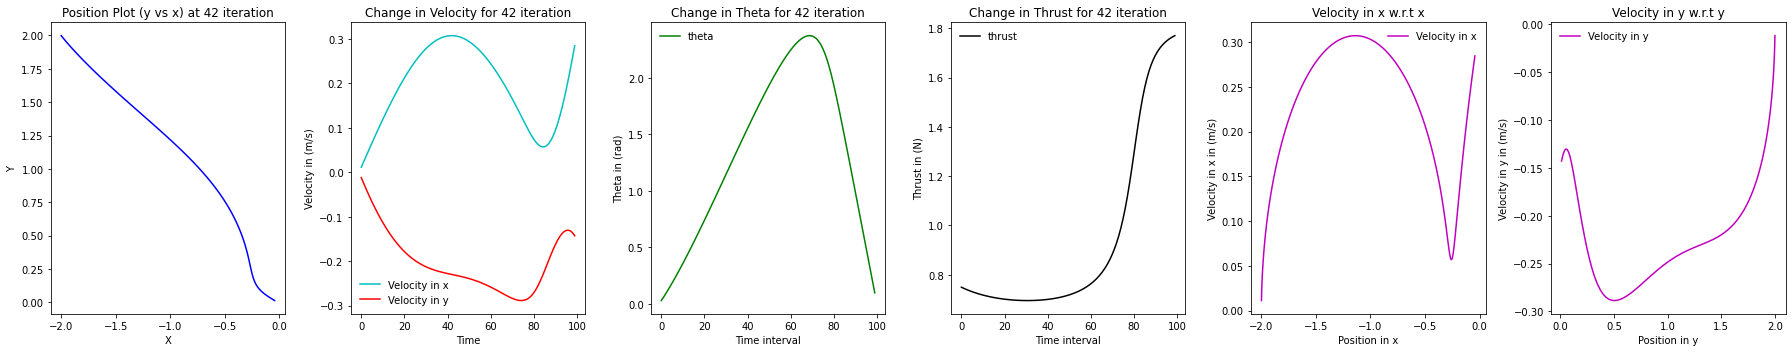

[43] loss: 0.021


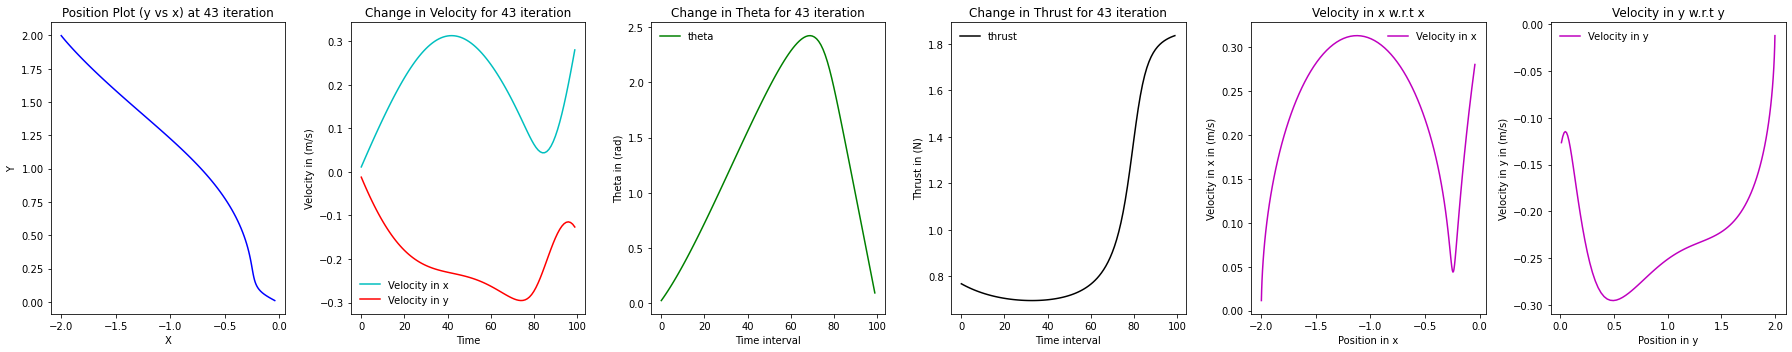

[44] loss: 0.019


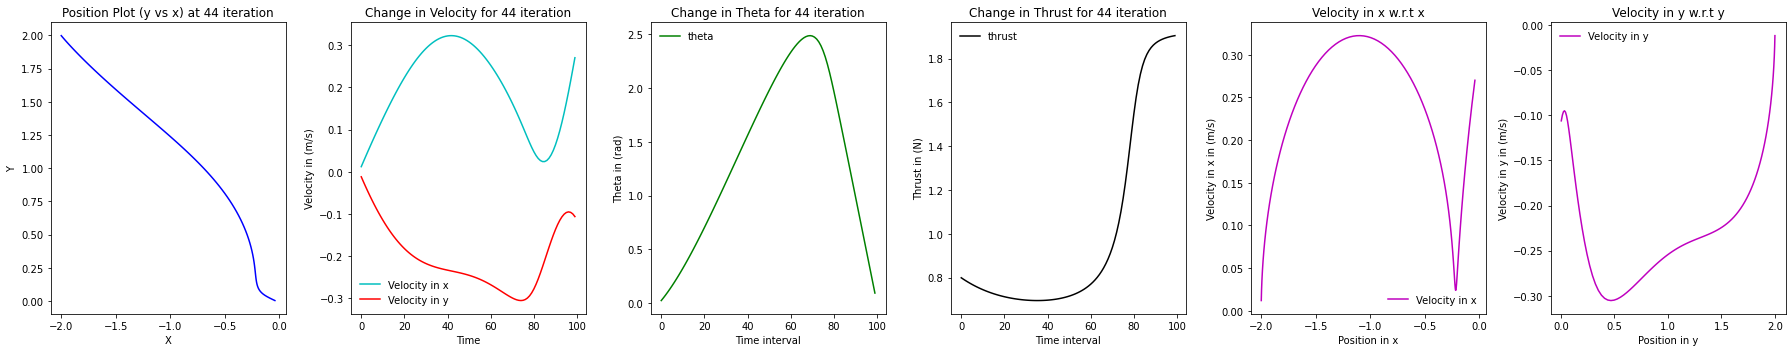

[45] loss: 0.016


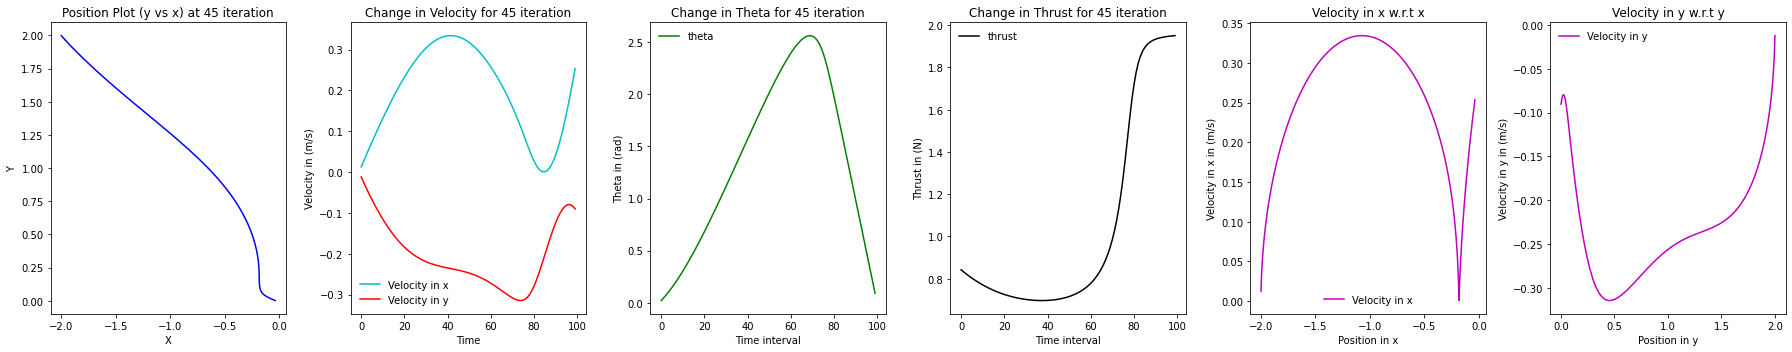

[46] loss: 0.014


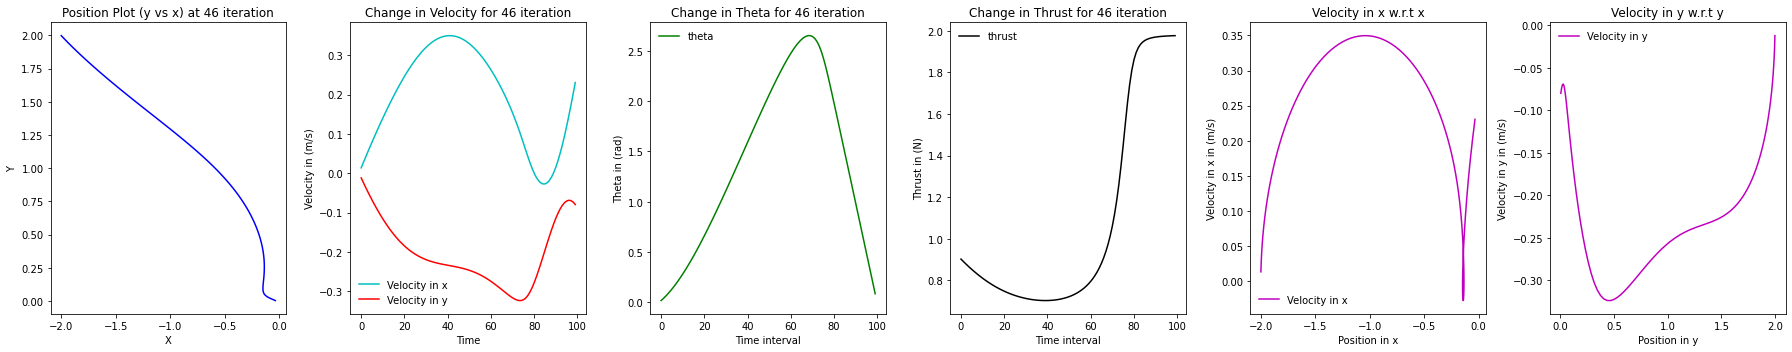

[47] loss: 0.011


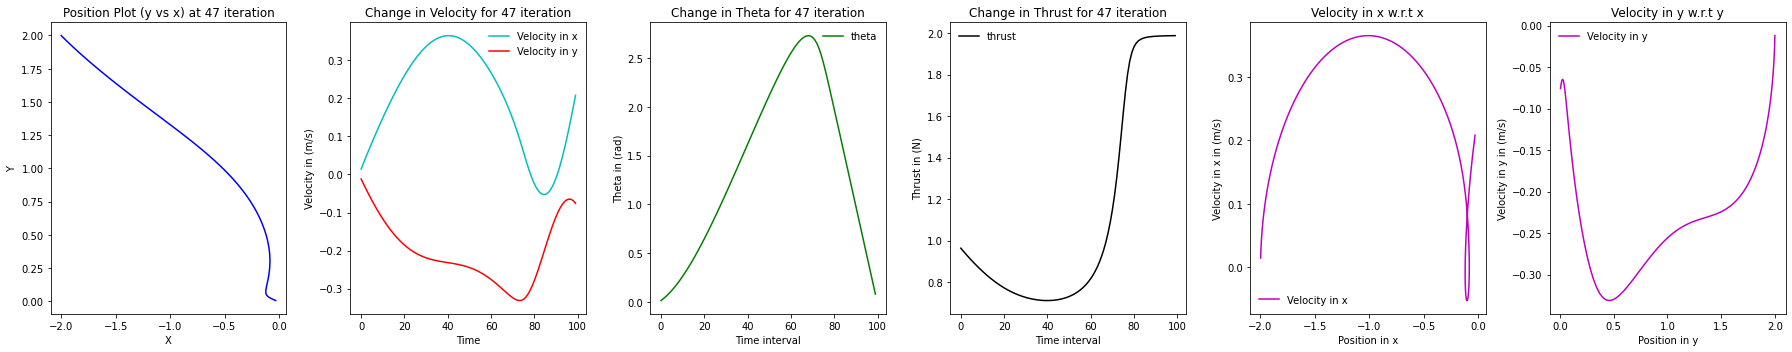

[48] loss: 0.009


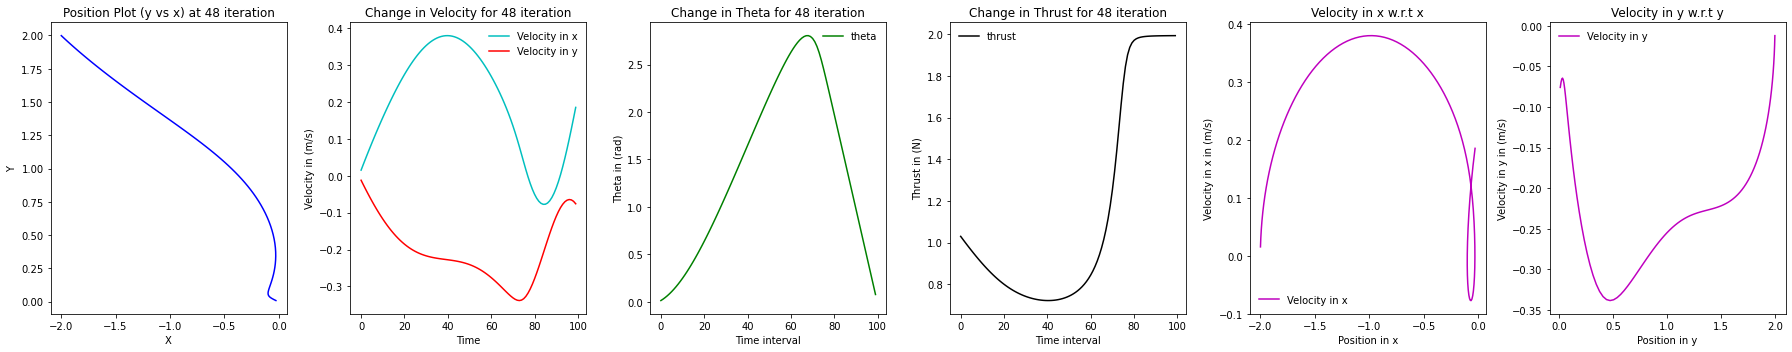

[49] loss: 0.008


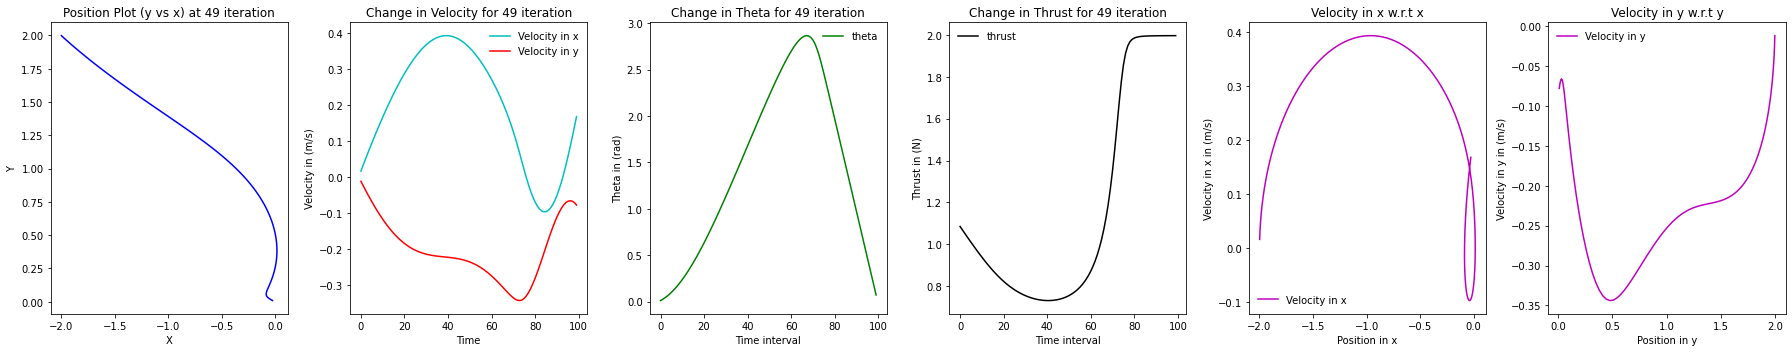

[50] loss: 0.007


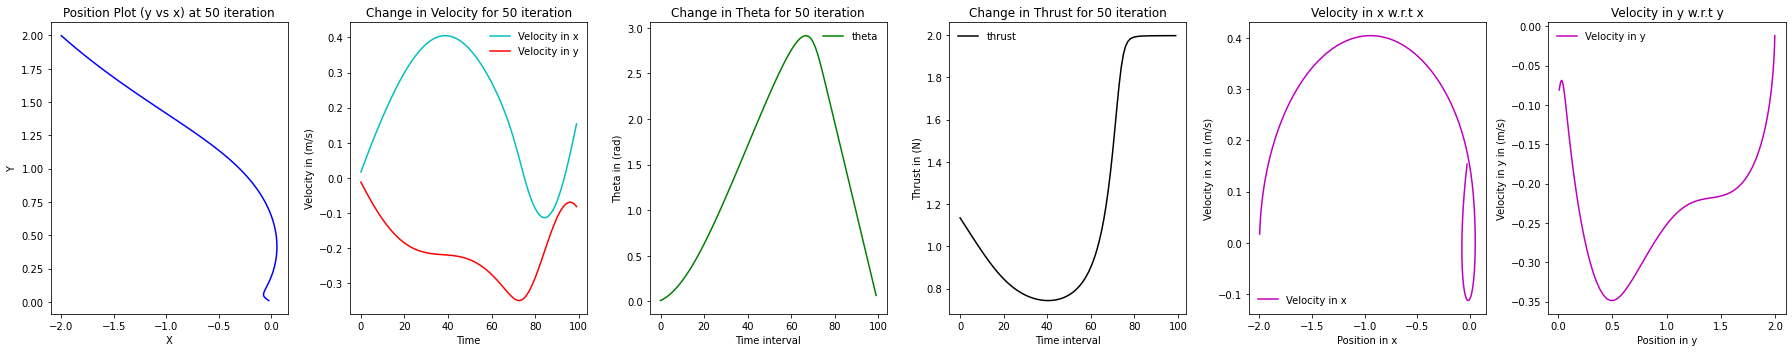

[51] loss: 0.006


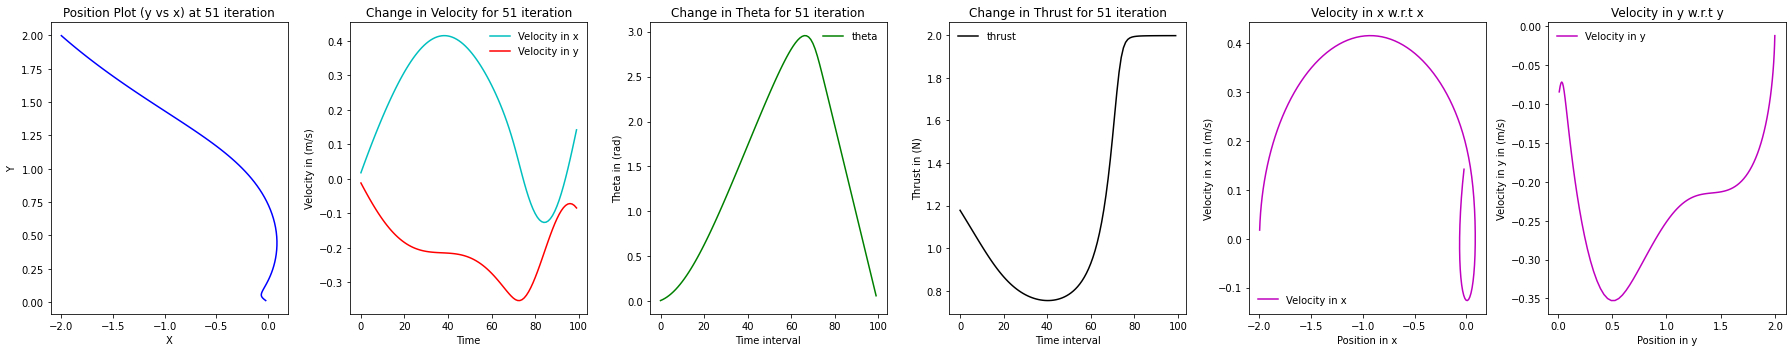

[52] loss: 0.006


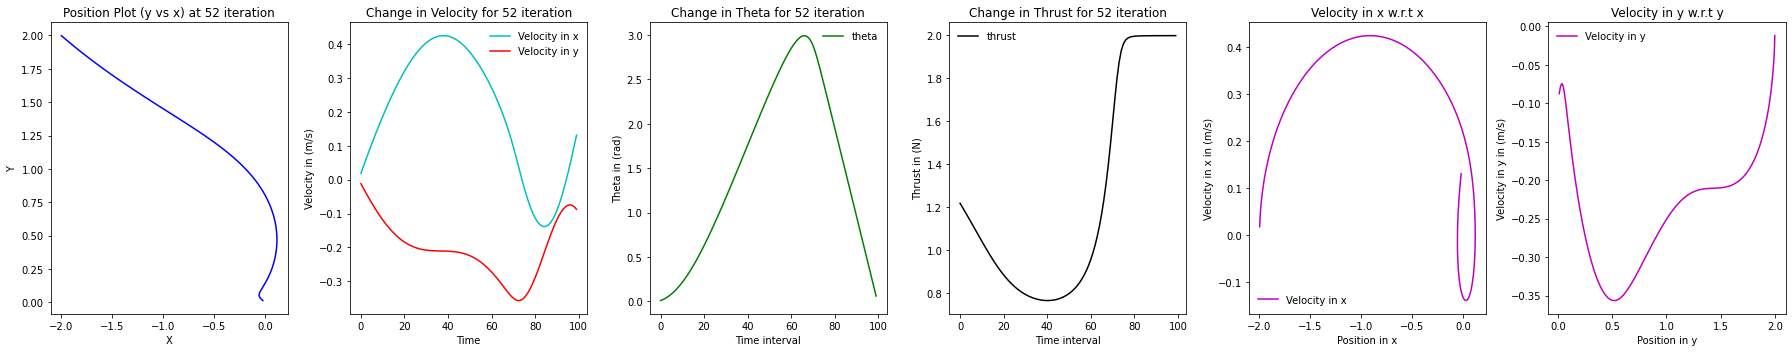

[53] loss: 0.005


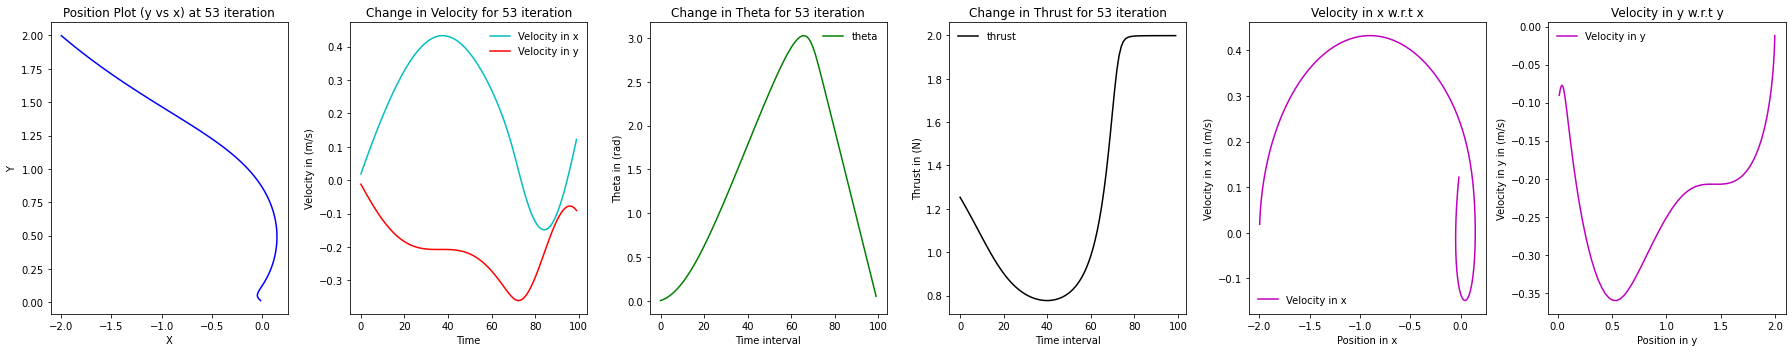

[54] loss: 0.005


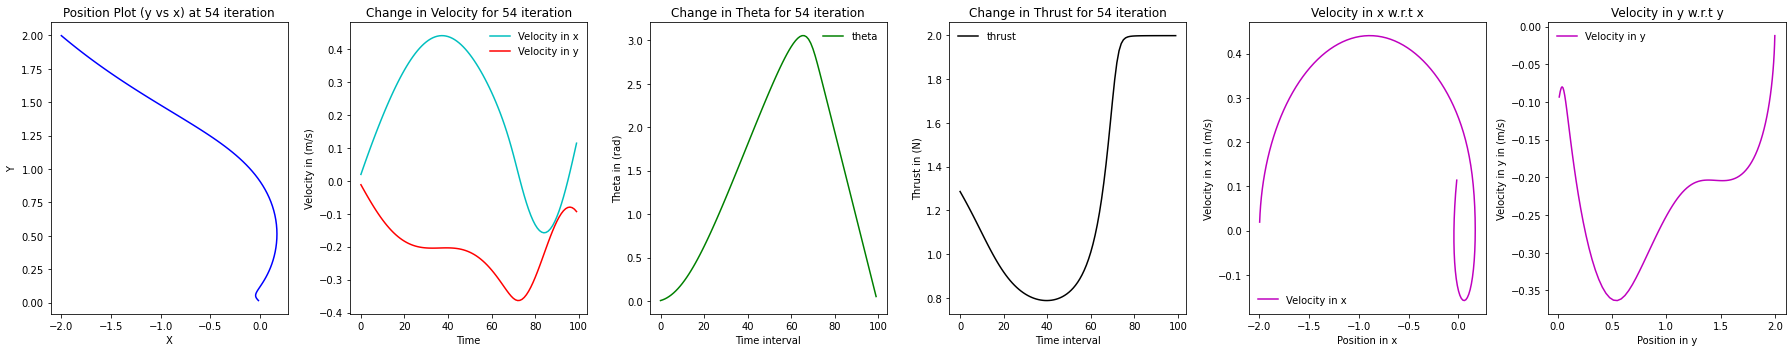

[55] loss: 0.005


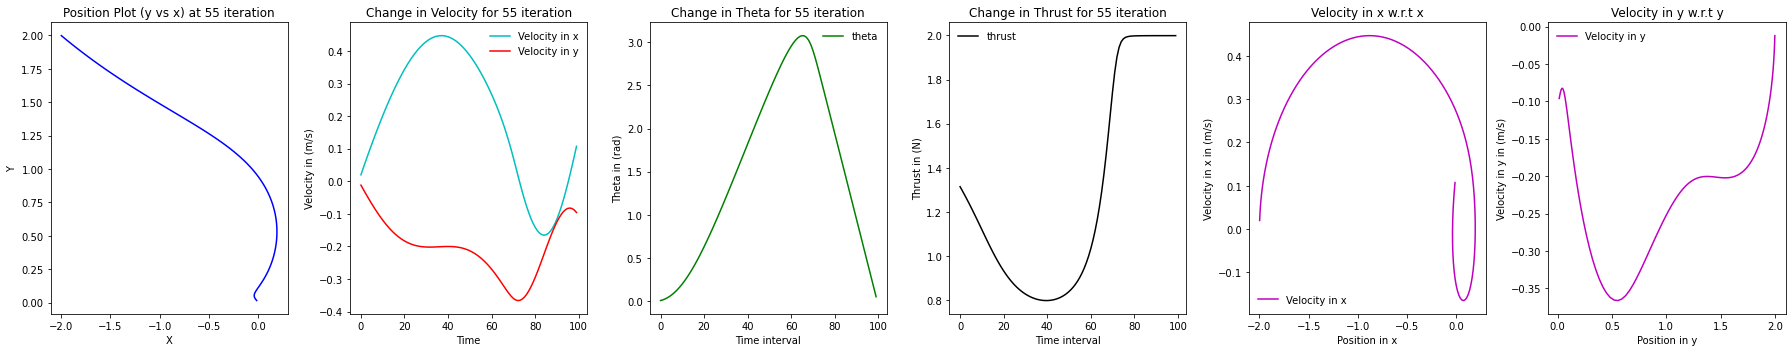

[56] loss: 0.005


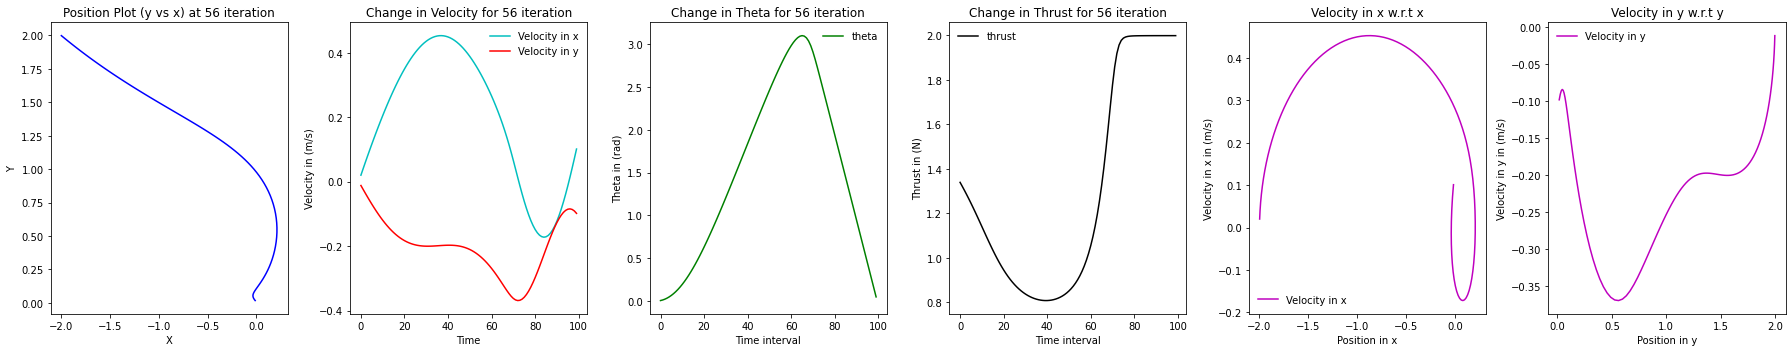

[57] loss: 0.004


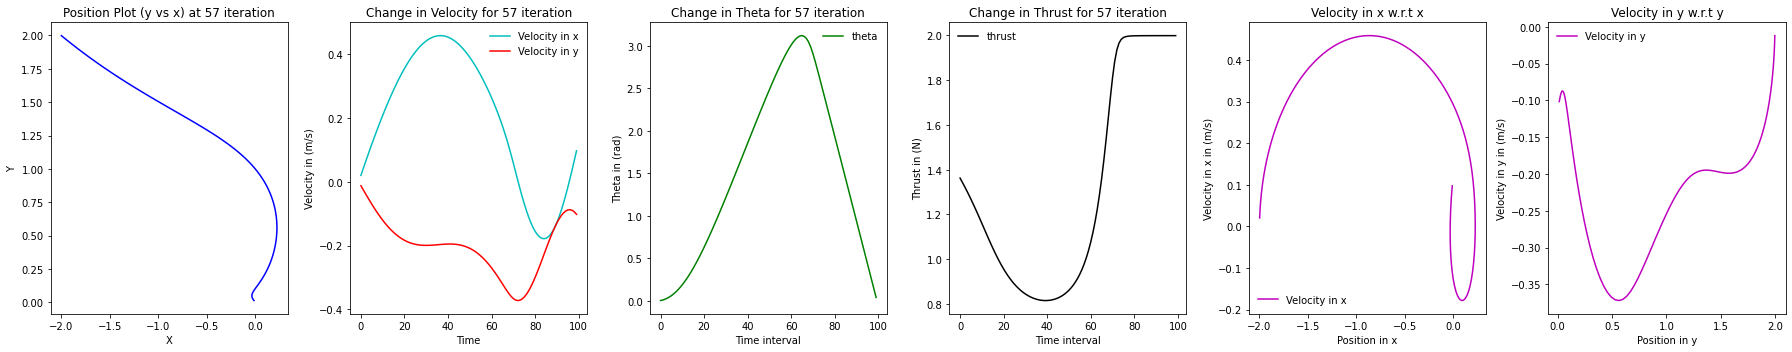

[58] loss: 0.004


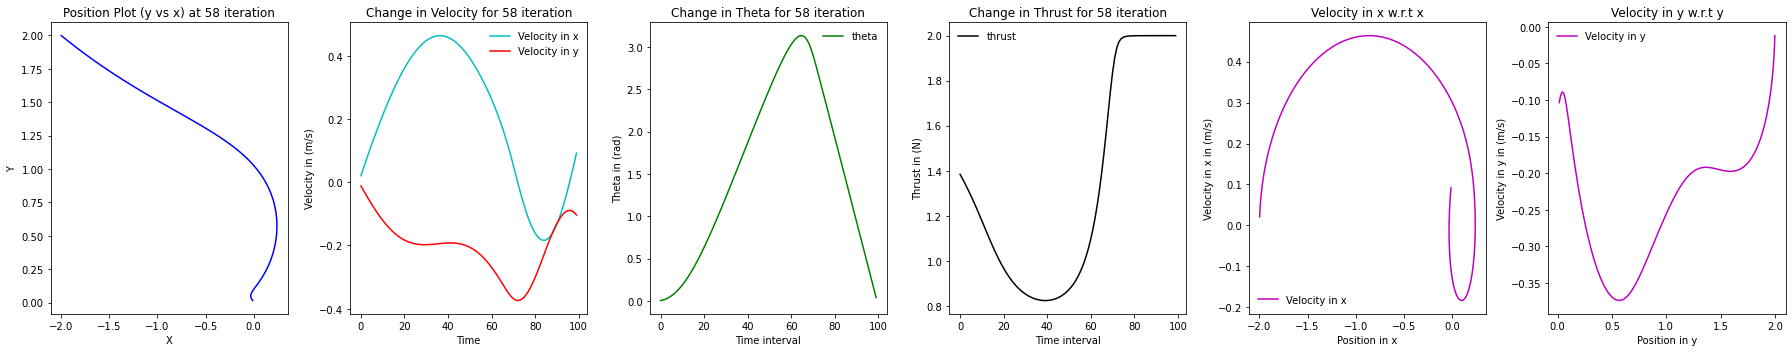

[59] loss: 0.004


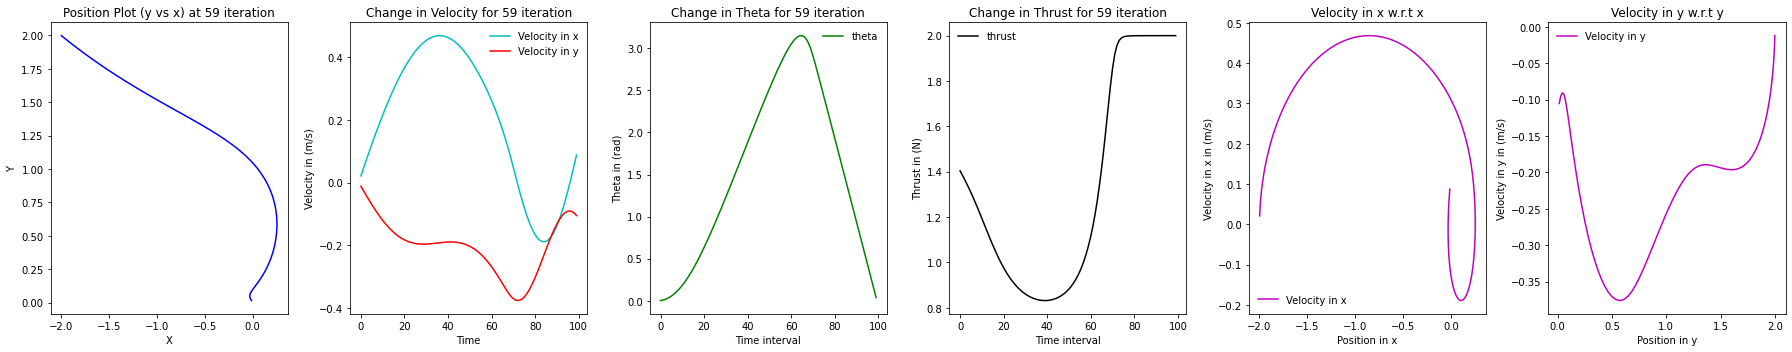

[60] loss: 0.004


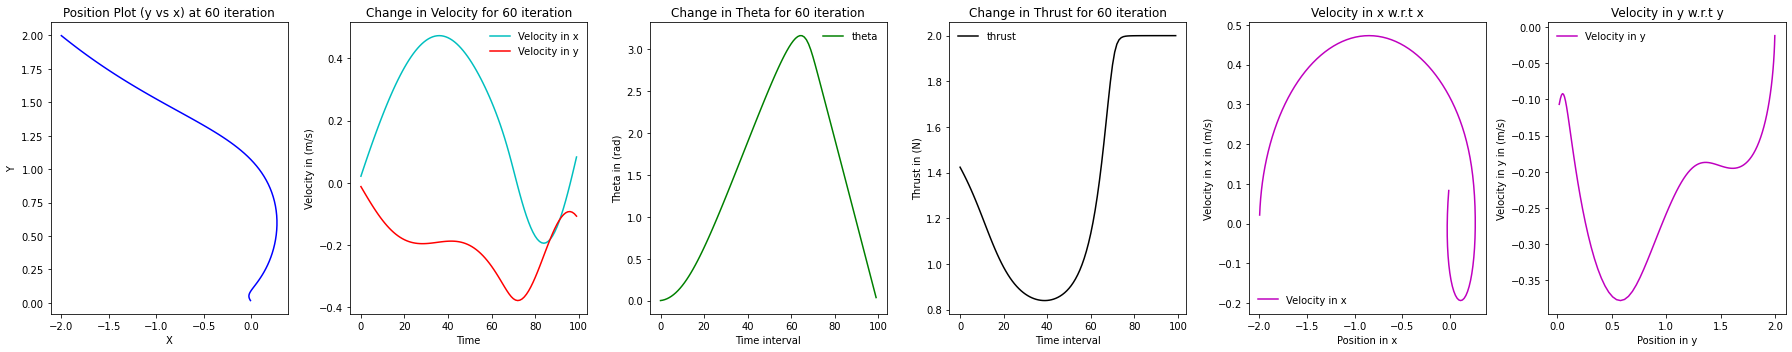

[61] loss: 0.004


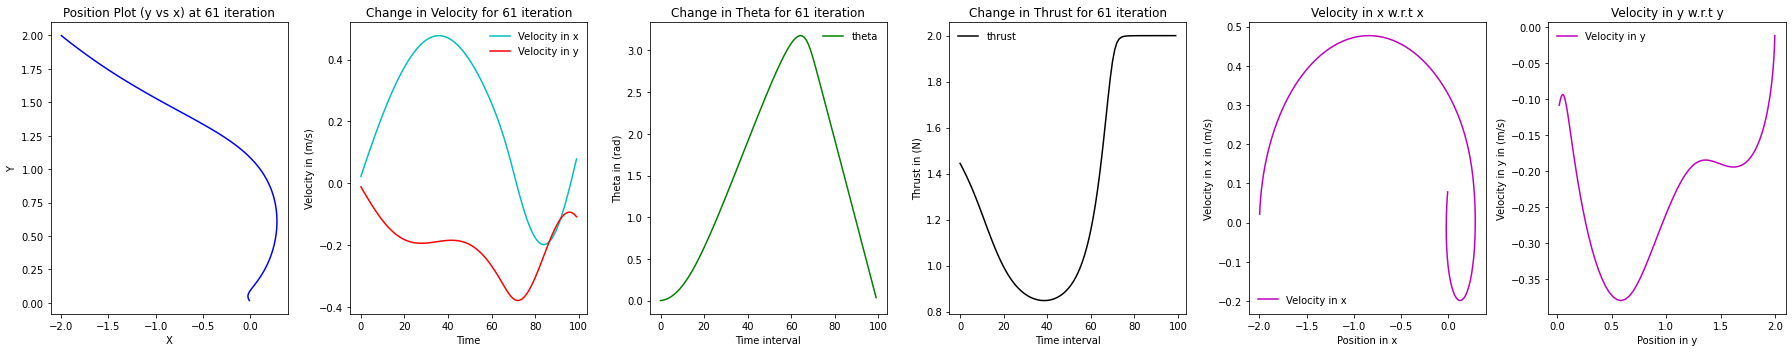

[62] loss: 0.004


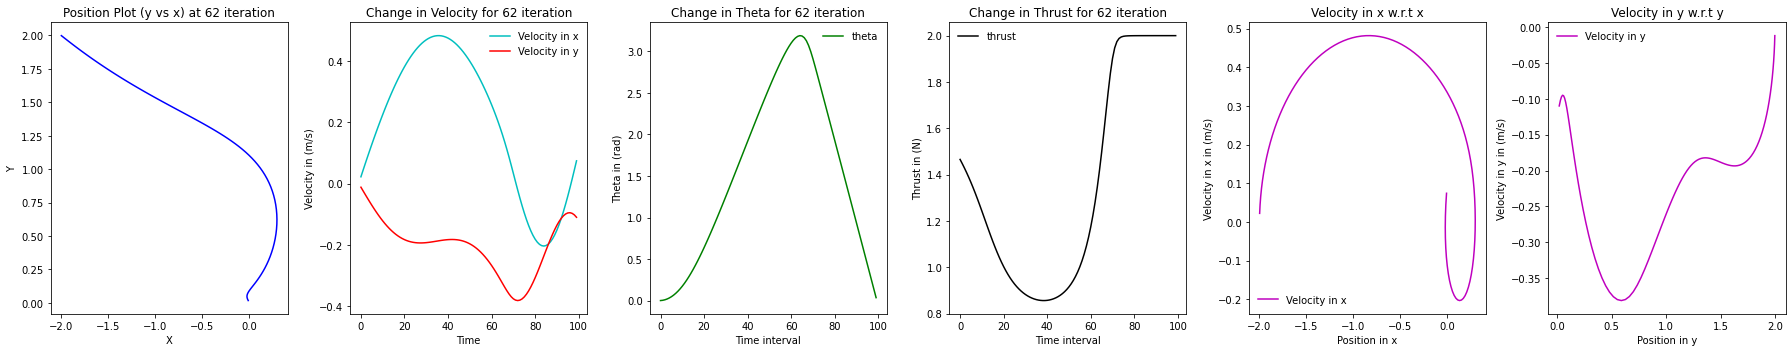

[63] loss: 0.004


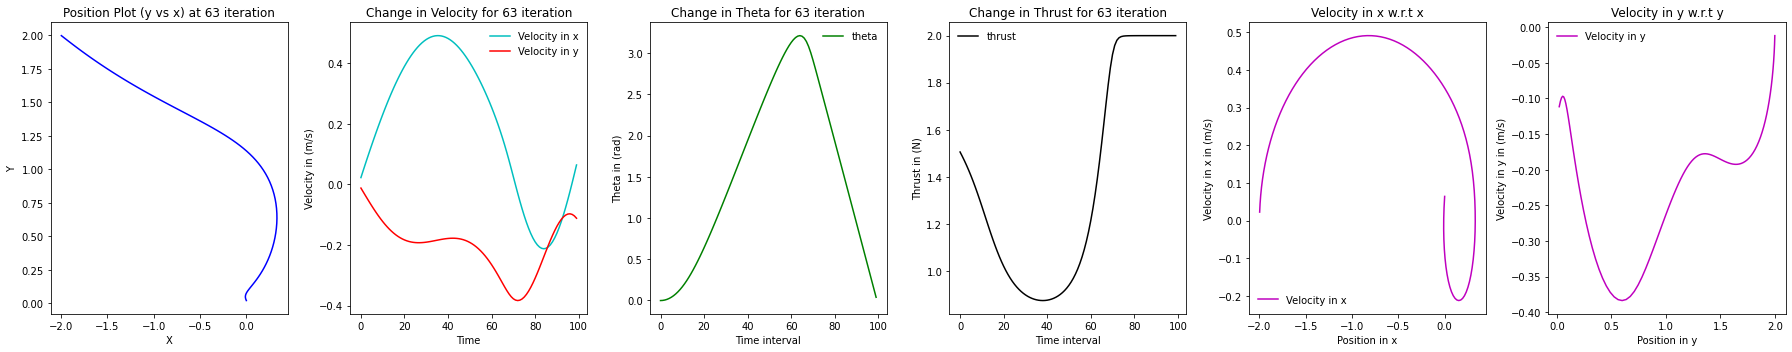

[64] loss: 0.004


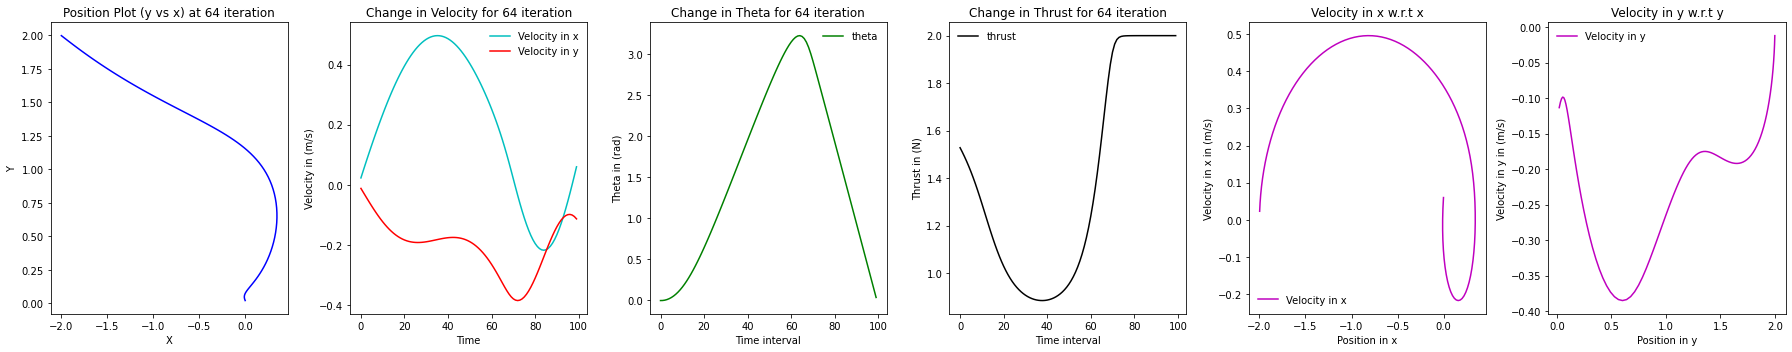

[65] loss: 0.004


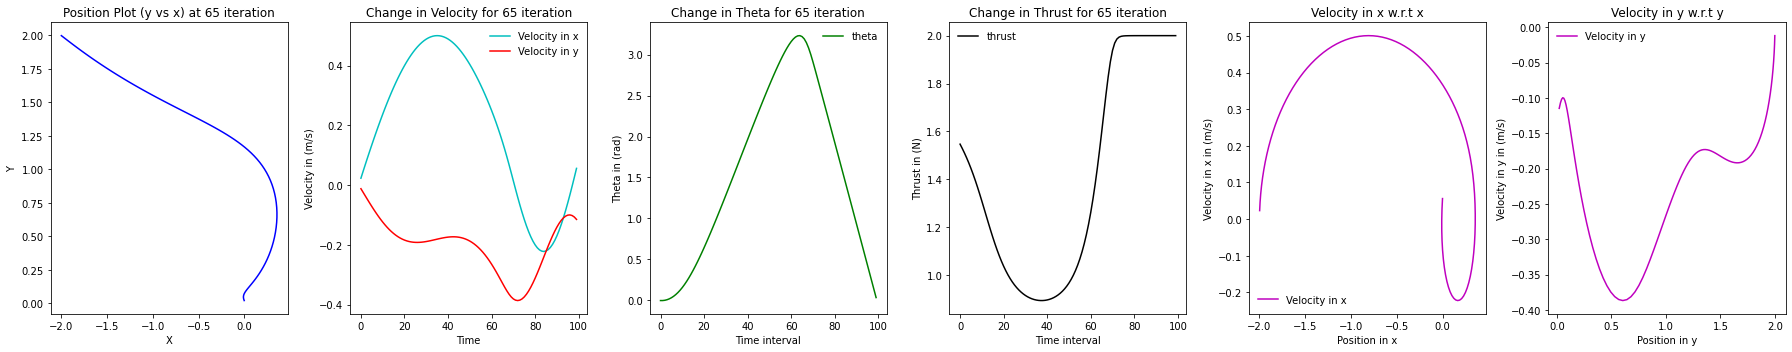

[66] loss: 0.004


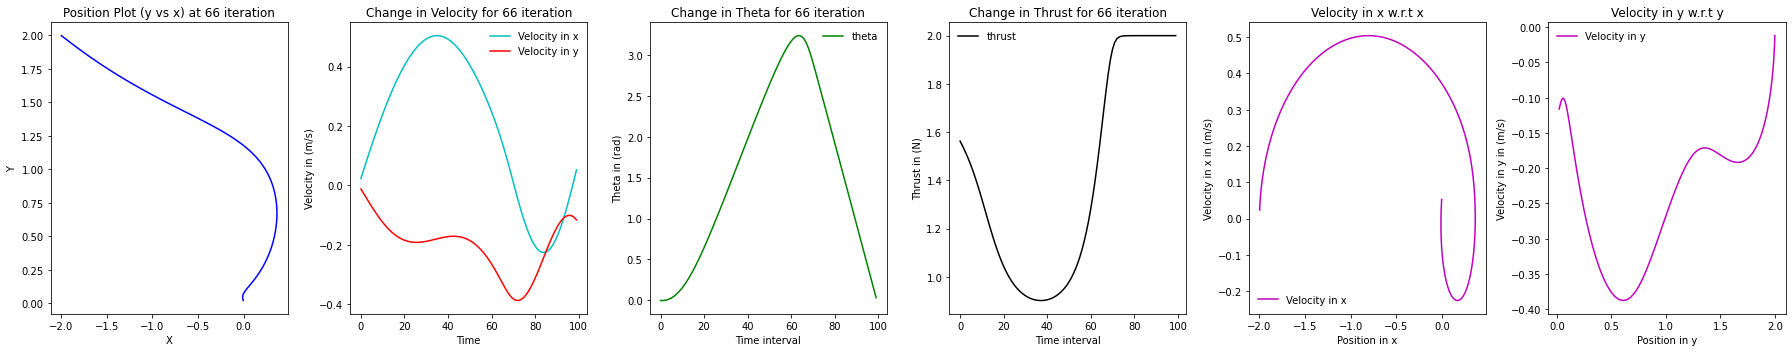

[67] loss: 0.003


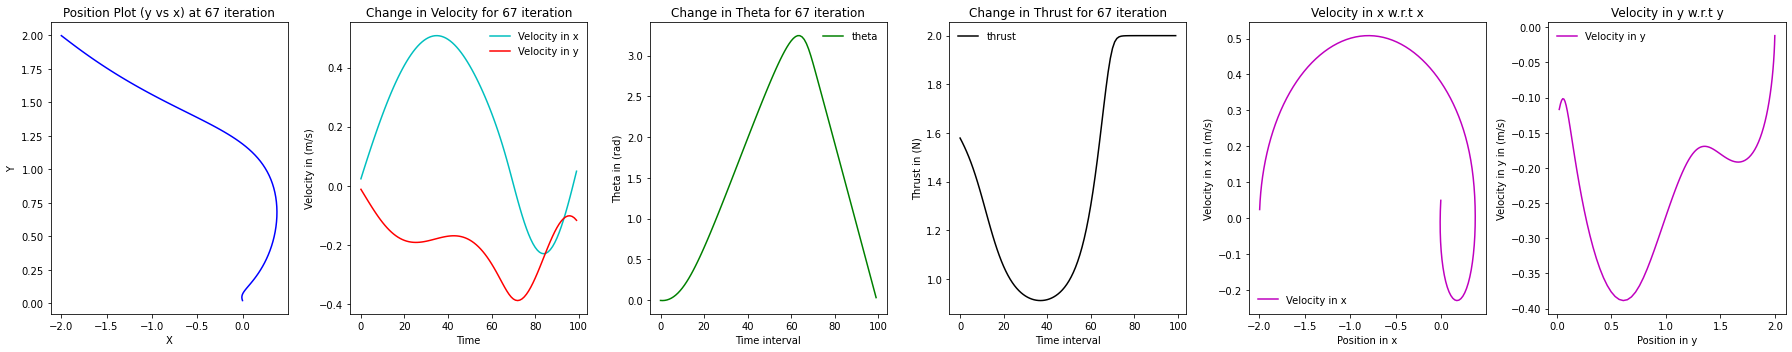

[68] loss: 0.003


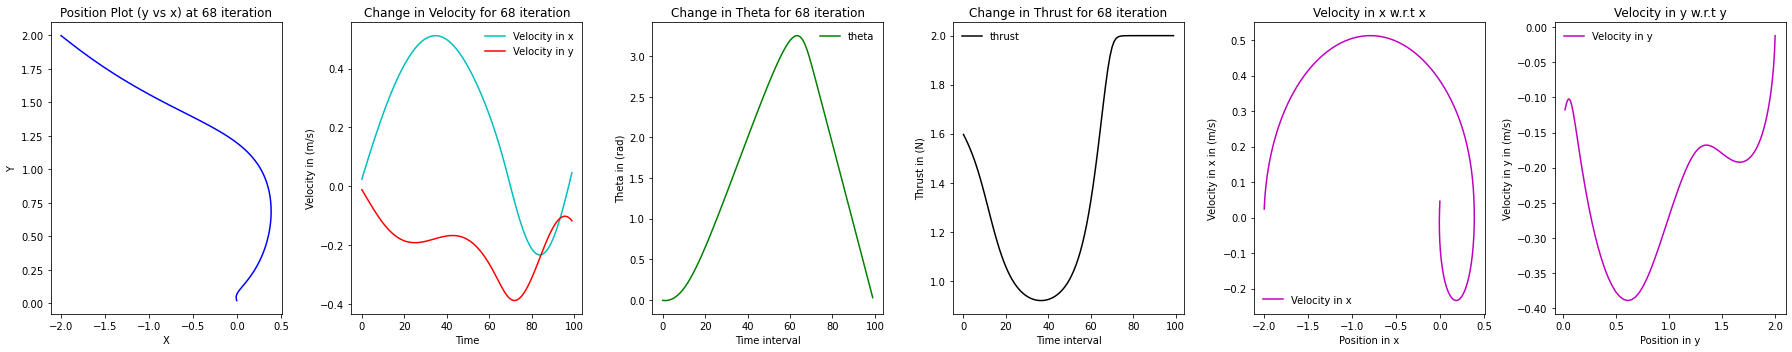

[69] loss: 0.003


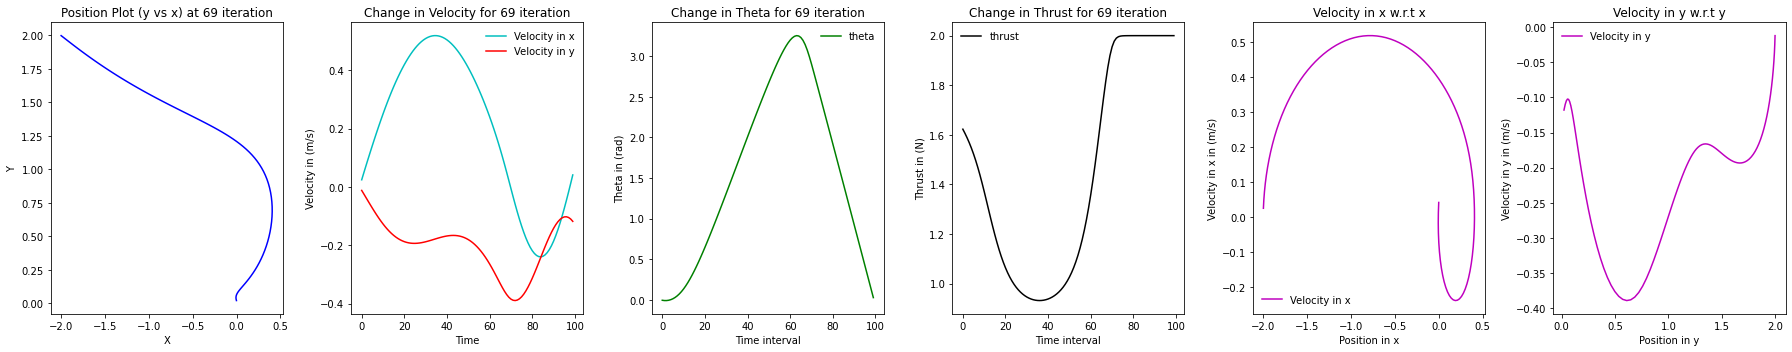

[70] loss: 0.003


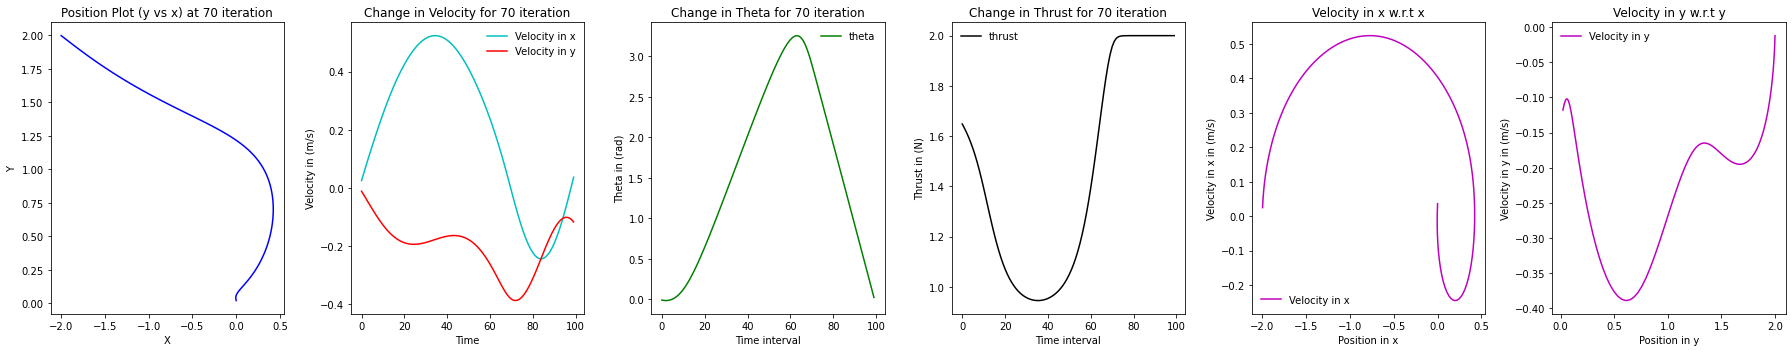

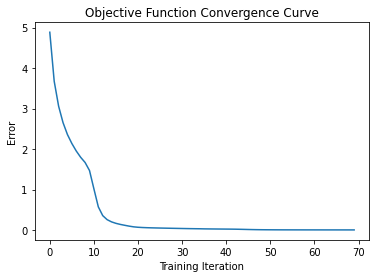

In [ ]:
##input 

T = 100  
# number of time steps

dim_input = 5  
# state space dimensions

dim_hidden = 6  
# latent dimensions

dim_output = 2  
# action space dimensions

d = Dynamics()  

c = Controller(dim_input, dim_hidden, dim_output)  

s = Simulation(c, d, T)  

o = Optimize(s)  

o.train(70)  
# training with number of epochs
